# Advanced Customer Segmentation: Combining K-Means, PCA, and Generative AI for Personalized Marketing Recommendations

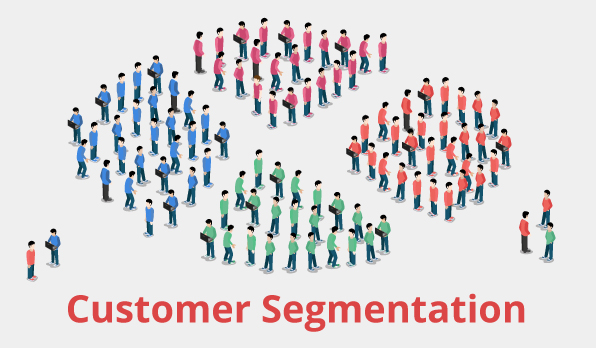

## Project Overview
In this data science project, we implement sophisticated customer segmentation techniques to identify distinct customer segments and develop targeted marketing strategies.
____


**Brief Project Overview**  
This project analyzes the Mall Customers dataset (Gender, Age, Income, Spending Score) to discover distinct customer segments and inform targeted marketing. We use **K-Means** (validated with Elbow and Silhouette methods) and **PCA** for dimensionality reduction. After segmenting customers, we profile each group’s demographic and spending behaviors. We then leverage **AI/LLM tools** (LangChain, Cosine Similarity) to create personalized marketing strategies and product recommendations. Finally, we assess potential **business impact** by estimating revenue gains, identifying cross‐sell/upsell opportunities, and comparing personalized vs. generic campaigns.

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.pipeline import make_pipeline
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import GridSearchCV
import matplotlib.cm as cm

import warnings
warnings.filterwarnings("ignore")

# Set styling for better visualizations
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("viridis")

## 1. Dataset Overview and Loading

In [2]:
# Load the dataset
df = pd.read_csv("Dataset/Mall_Customers.csv")

# Display basic information
print(f"Dataset shape: {df.shape}")
print("\nFirst 5 rows:")
display(df.head())

# Summary statistics
display(df.describe())

# Data types and missing values
print("\nData Types:")
display(df.dtypes)
print("\nMissing Values:")
display(df.isnull().sum())

Dataset shape: (200, 5)

First 5 rows:


CustomerID  Gender  Age  Annual Income (k$)  Spending Score (1-100)
0           1    Male   19                  15                      39
1           2    Male   21                  15                      81
2           3  Female   20                  16                       6
3           4  Female   23                  16                      77
4           5  Female   31                  17                      40

CustomerID         Age  Annual Income (k$)  Spending Score (1-100)
count  200.000000  200.000000          200.000000              200.000000
mean   100.500000   38.850000           60.560000               50.200000
std     57.879185   13.969007           26.264721               25.823522
min      1.000000   18.000000           15.000000                1.000000
25%     50.750000   28.750000           41.500000               34.750000
50%    100.500000   36.000000           61.500000               50.000000
75%    150.250000   49.000000           78.000000               73.000000
max    200.000000   70.000000          137.000000               99.000000


Data Types:


CustomerID                 int64
Gender                    object
Age                        int64
Annual Income (k$)         int64
Spending Score (1-100)     int64
dtype: object


Missing Values:


CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

## 2. Comprehensive Exploratory Data Analysis

In [3]:
# Create a copy of the dataframe for analysis, removing CustomerID
df_analysis = df.drop("CustomerID", axis=1).copy()

In [4]:
# Convert Gender to numeric for analysis
df_analysis['Gender'] = df_analysis['Gender'].map({'Male': 1, 'Female': 0})


### Distribution of numerical features

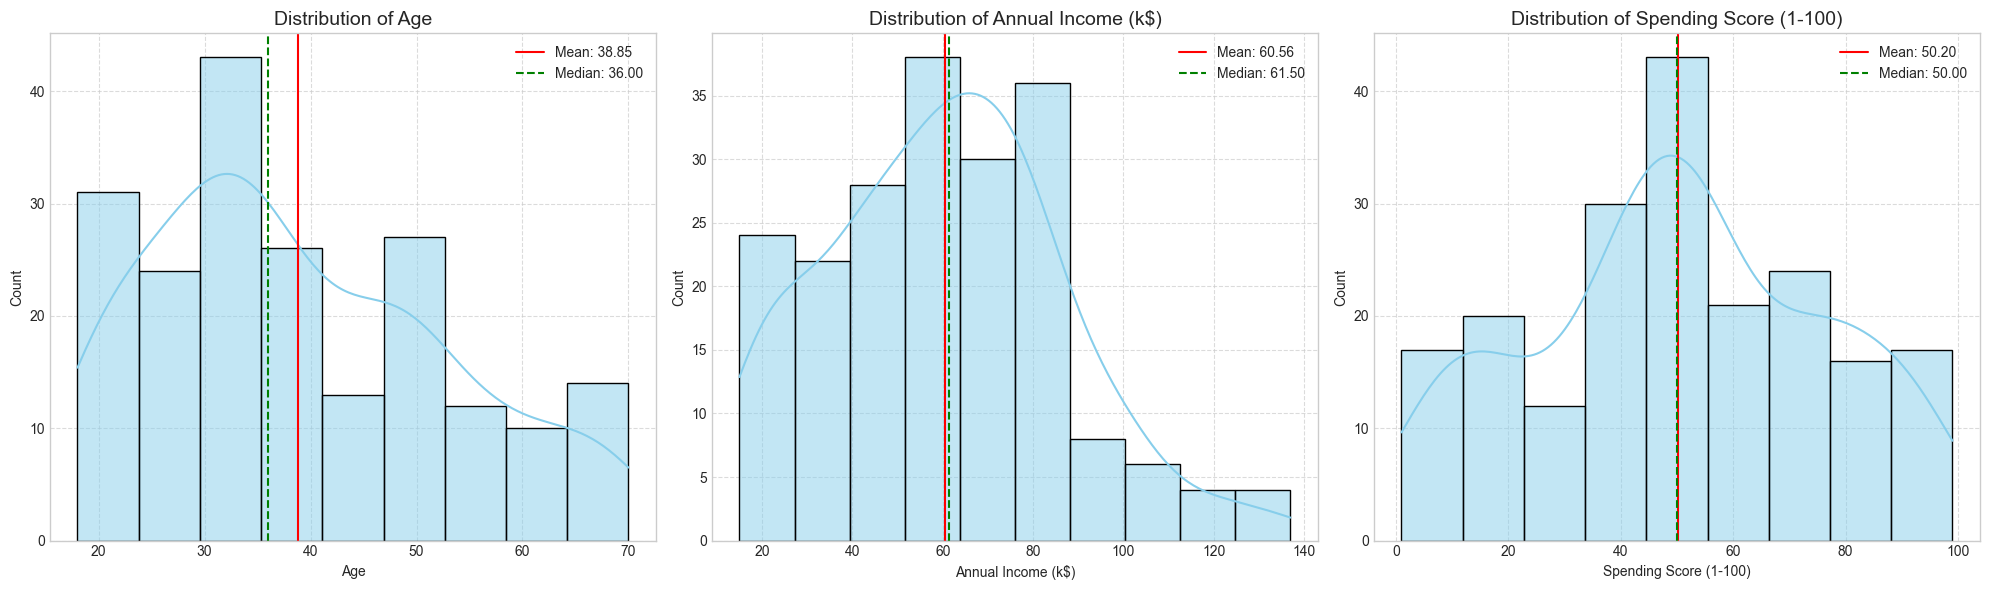

In [5]:
# Distribution of numerical features
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
features = ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']

for i, feature in enumerate(features):
    sns.histplot(df_analysis[feature], kde=True, ax=axes[i], color='skyblue')
    axes[i].set_title(f'Distribution of {feature}', fontsize=14)
    axes[i].grid(True, linestyle='--', alpha=0.7)
    
    # Add mean and median lines
    mean_val = df_analysis[feature].mean()
    median_val = df_analysis[feature].median()
    axes[i].axvline(mean_val, color='red', linestyle='-', label=f'Mean: {mean_val:.2f}')
    axes[i].axvline(median_val, color='green', linestyle='--', label=f'Median: {median_val:.2f}')
    axes[i].legend()

plt.tight_layout()
plt.show()

#### Interpretation of the Histograms

**Age**  
- Ages go from about 20 to 70.  
- Most people are in their 30s and 40s.  
- Average age is about 39, with half below 36.

**Annual Income**  
- Incomes range from around \$15,000 to over \$130,000.  
- Most people earn around \$60,000 a year.  
- Average is about \$62,000, close to the midpoint.

**Spending Score (1–100)**  
- Scores run from 1 to 100.  
- Most scores cluster around 50.  
- Average is about 50, which matches the middle value.

2. **Data Exploration and Visualization:**
   - Conduct exploratory data analysis (EDA) using histograms, scatter plots,Correlation matrix ,  and pair plots.
   - Visualize feature distributions and potential correlations.
_____

### - Gender distribution

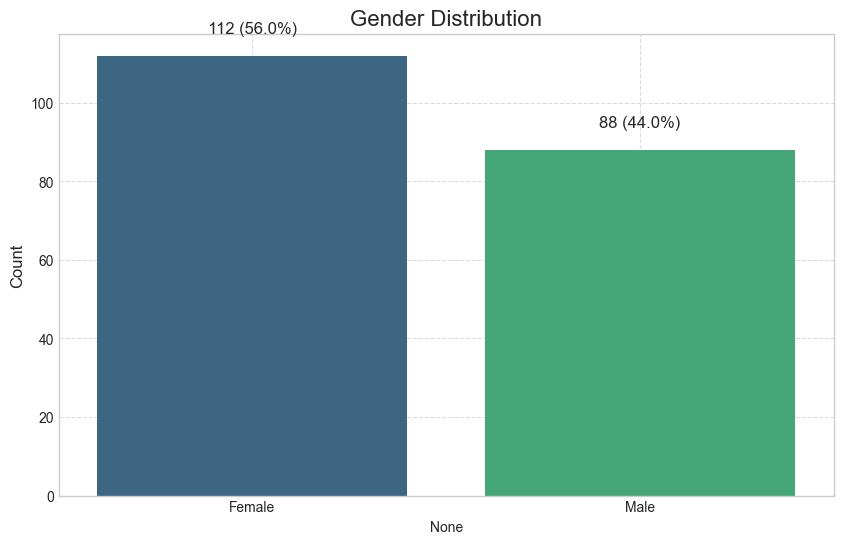

In [6]:
# Gender distribution
plt.figure(figsize=(10, 6))
gender_counts = df['Gender'].value_counts()
sns.barplot(x=gender_counts.index, y=gender_counts.values, palette="viridis")
plt.title('Gender Distribution', fontsize=16)
plt.ylabel('Count', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

# Add count and percentage labels
total = gender_counts.sum()
for i, count in enumerate(gender_counts):
    percentage = 100 * count / total
    plt.text(i, count + 5, f'{count} ({percentage:.1f}%)', 
             ha='center', va='bottom', fontsize=12)

plt.show()


#### - Pair plot for all numerical features

<Figure size 1200x1000 with 0 Axes>

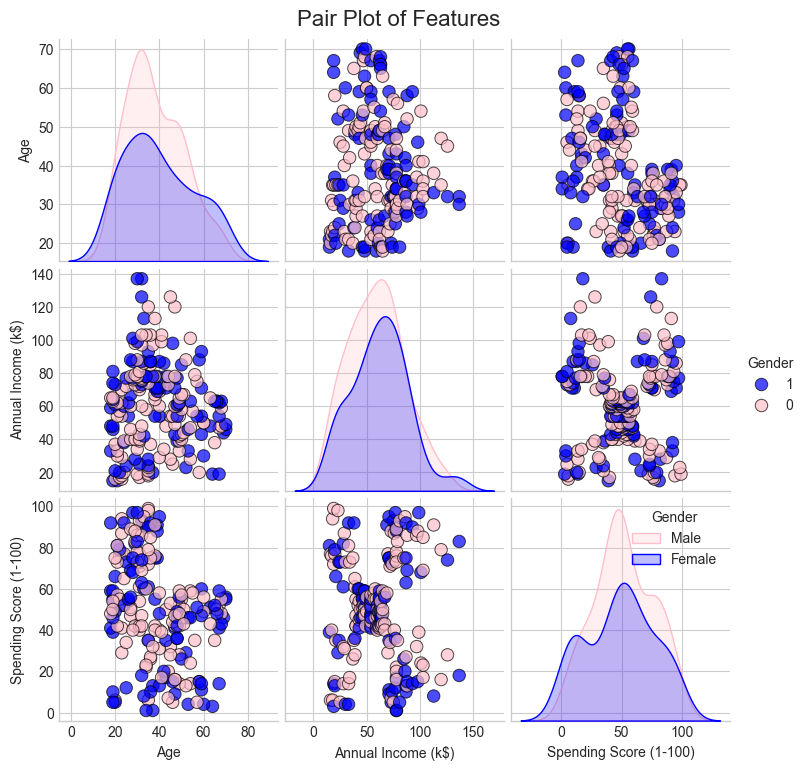

In [7]:

# Pair plot for all numerical features
plt.figure(figsize=(12, 10))
sns.pairplot(df_analysis, hue='Gender', palette={0: 'pink', 1: 'blue'}, 
             hue_order=[1, 0], plot_kws={'alpha': 0.7, 's': 80, 'edgecolor': 'k'})

# Add legend labels manually
def new_func():
    plt.legend(title='Gender', labels=['Male', 'Female'], loc='upper right')

new_func()
plt.suptitle('Pair Plot of Features', y=1.02, fontsize=16)
plt.show()

- **Age vs. Annual Income:**  
  People of all ages have different incomes. There's no clear pattern.

- **Age vs. Spending Score:**  
  Both young and old people can have high or low spending scores.

- **Annual Income vs. Spending Score:**  
  There might be a small link, but it's not very strong.

- **Gender:**  
  The colors show that males and females are mixed together. Gender does not change the other numbers much.

__________

#### -  Correlation matrix with heatmap

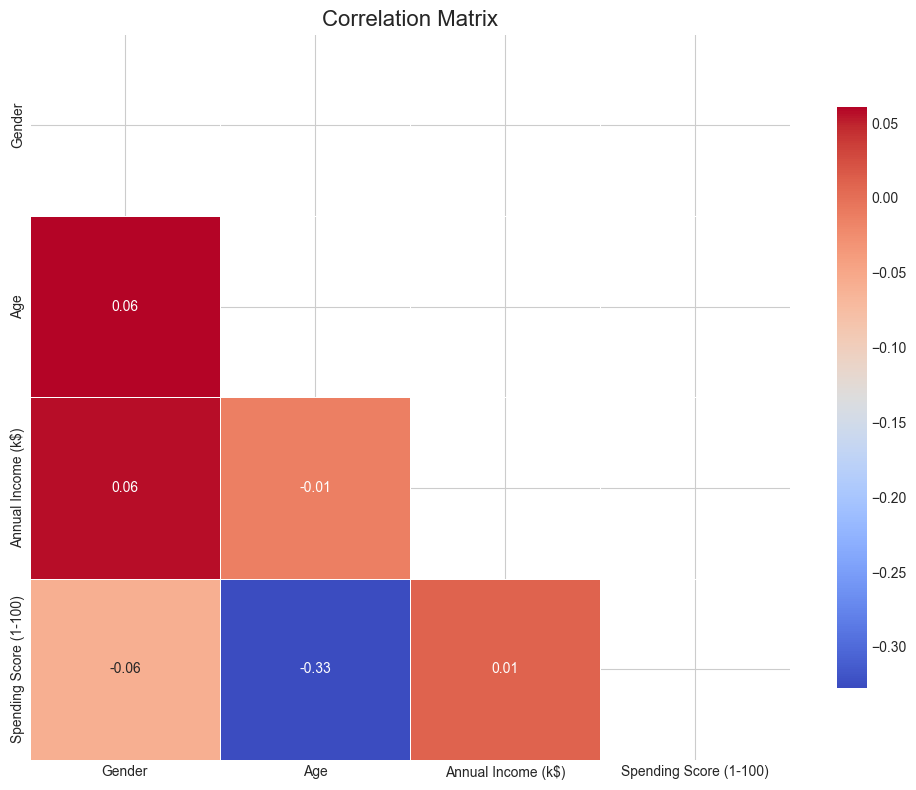

In [8]:
# Correlation matrix with heatmap
plt.figure(figsize=(10, 8))
correlation = df_analysis.corr()
mask = np.triu(np.ones_like(correlation, dtype=bool))
sns.heatmap(correlation, annot=True, fmt='.2f', cmap='coolwarm', 
            mask=mask, linewidths=0.5, cbar_kws={"shrink": .8})
plt.title('Correlation Matrix', fontsize=16)
plt.tight_layout()
plt.show()

**Observations (in simple terms):**  
- **Gender** has almost no correlation with **Age**, **Income**, or **Spending Score**.  
- **Age** and **Spending Score** have a moderate negative correlation (-0.33). Older people may tend to have lower spending scores.  
- **Income** has almost no correlation with **Age** or **Spending Score**.  

**Hypothesis:**  
Older customers might be more cautious or have different priorities, so they spend less (leading to lower scores). Gender and income do not seem to strongly affect spending behavior.

______

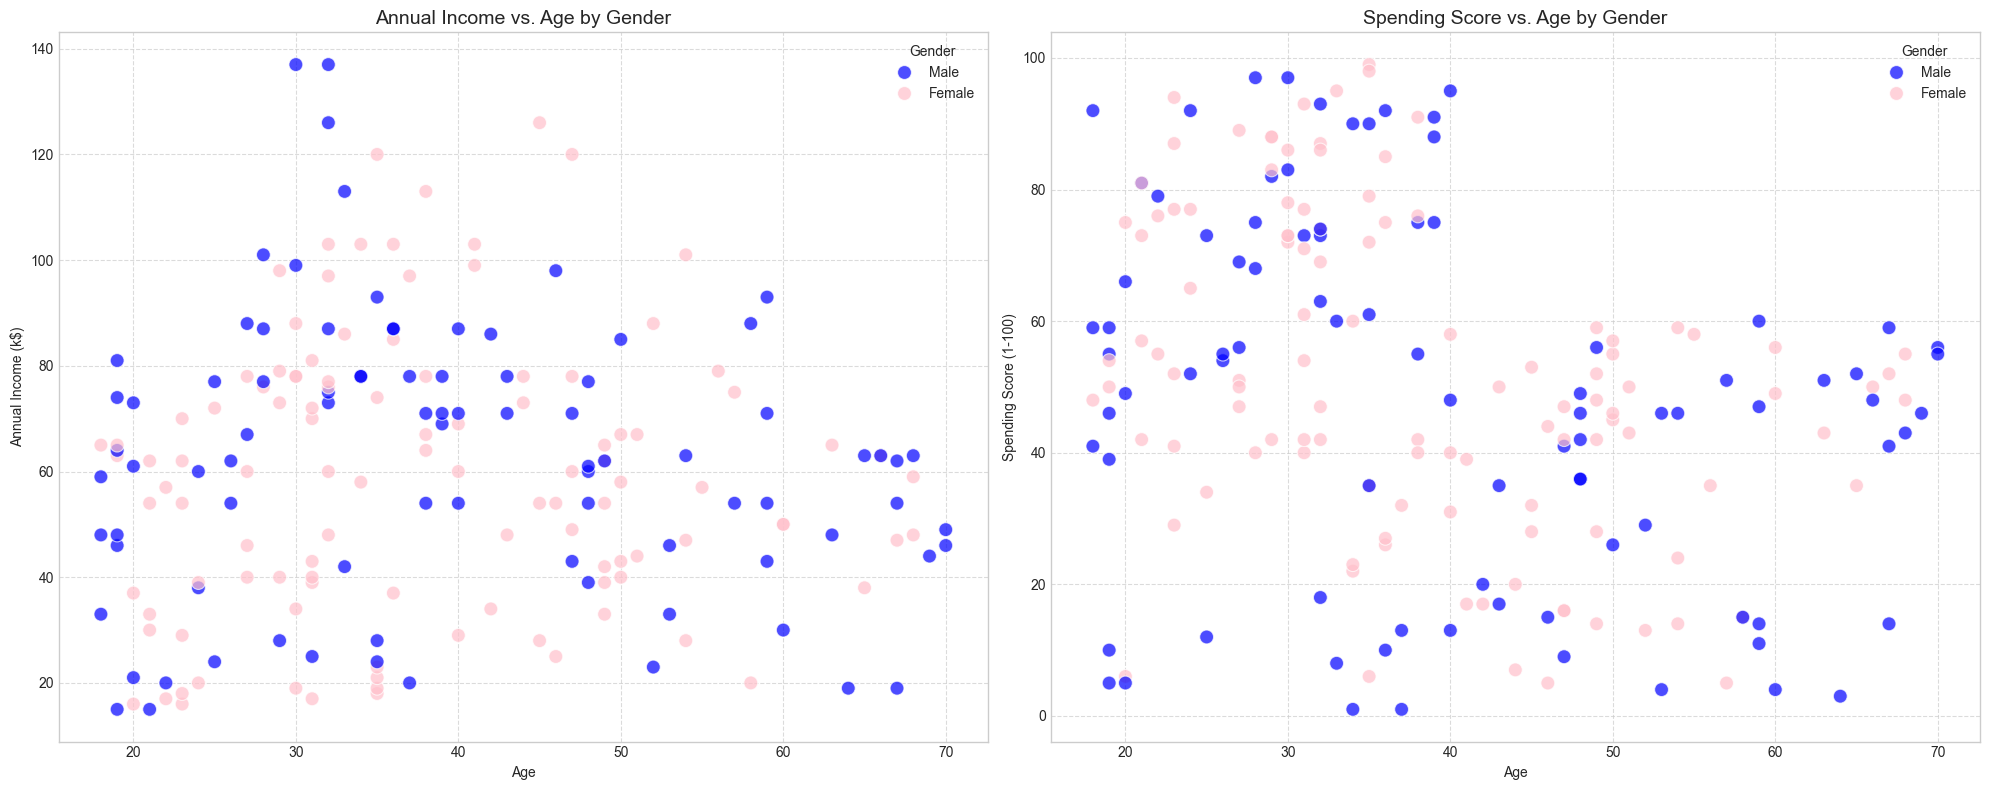

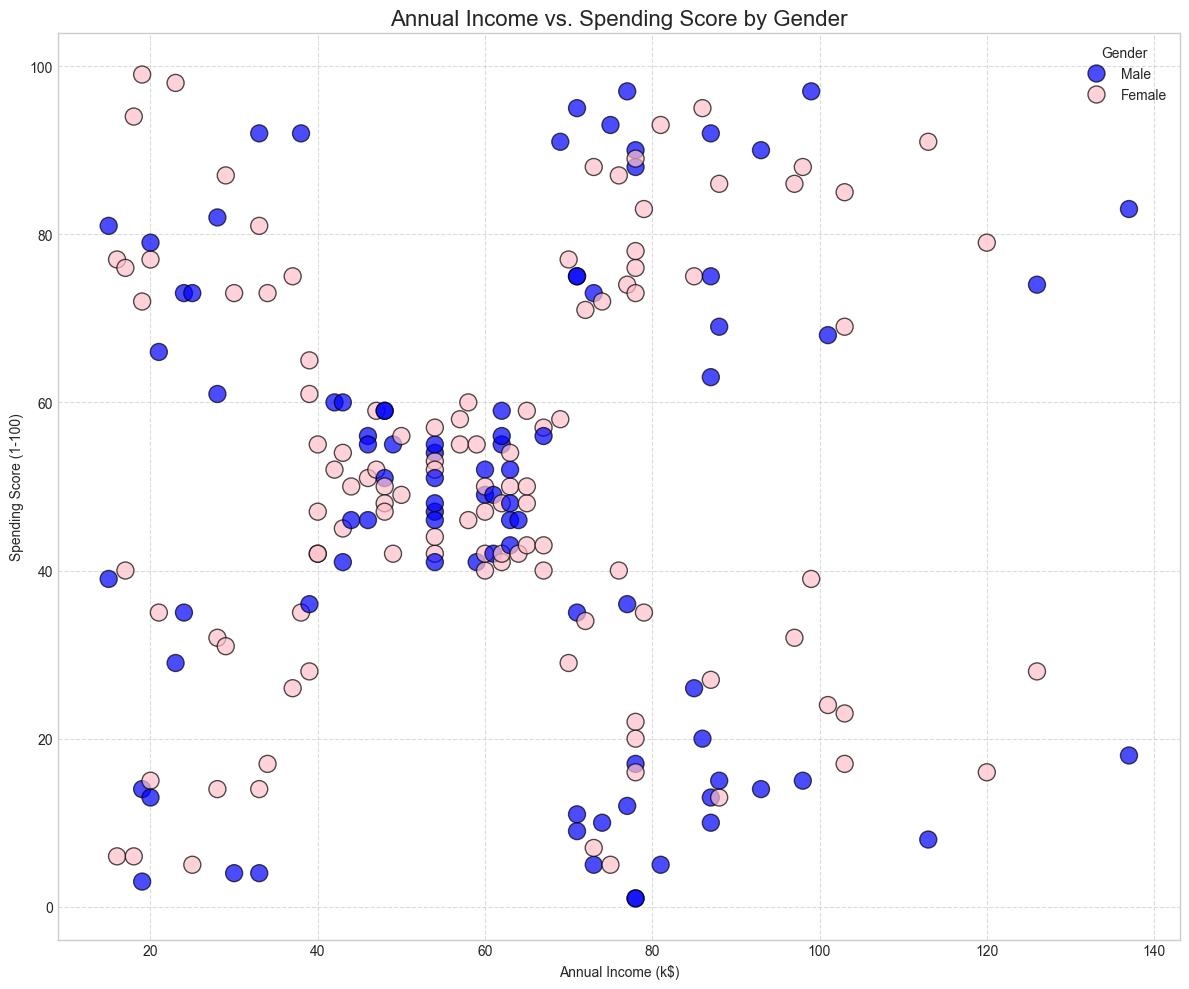

In [9]:

# Feature relationship analysis by gender
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Income vs. Age by Gender
sns.scatterplot(x='Age', y='Annual Income (k$)', 
                hue='Gender', data=df, palette={'Male': 'blue', 'Female': 'pink'}, 
                s=100, alpha=0.7, ax=axes[0])
axes[0].set_title('Annual Income vs. Age by Gender', fontsize=14)
axes[0].grid(True, linestyle='--', alpha=0.7)

# Spending Score vs. Age by Gender
sns.scatterplot(x='Age', y='Spending Score (1-100)', 
                hue='Gender', data=df, palette={'Male': 'blue', 'Female': 'pink'}, 
                s=100, alpha=0.7, ax=axes[1])
axes[1].set_title('Spending Score vs. Age by Gender', fontsize=14)
axes[1].grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# Key relationship: Income vs. Spending Score
plt.figure(figsize=(12, 10))
sns.scatterplot(x='Annual Income (k$)', y='Spending Score (1-100)', 
                hue='Gender', data=df, palette={'Male': 'blue', 'Female': 'pink'}, 
                s=150, alpha=0.7, edgecolor='k')
plt.title('Annual Income vs. Spending Score by Gender', fontsize=16)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

 ### Observations
1. **Age vs. Annual Income (by Gender)**  
   - People of all ages can have both high and low incomes.  
   - Males (blue) and females (pink) are scattered across the full range, so gender doesn’t show a clear effect.

2. **Age vs. Spending Score (by Gender)**  
   - Spending scores go down slightly as age goes up (older customers often have lower scores).  
   - Both males and females appear mixed in each age and score group.

3. **Annual Income vs. Spending Score (by Gender)**  
   - People with higher incomes can still have low or high spending scores.  
   - There’s no obvious split between males and females here either.

### Simple Hypothesis
Older customers may spend less on average, while income and gender do not seem to strongly affect spending patterns.


_______

## 3. Data Preprocessing

- Feature transformations

In [10]:
# Create a preprocessing function to handle all preprocessing steps
def preprocess_data(data):
    # Create a copy to avoid modifying the original dataframe
    df_processed = data.copy()
    
    # Drop CustomerID as it's not relevant for clustering
    if 'CustomerID' in df_processed.columns:
        df_processed.drop('CustomerID', axis=1, inplace=True)
    
    # Convert Gender to numeric: Male -> 1, Female -> 0
    if 'Gender' in df_processed.columns:
        df_processed['Gender'] = df_processed['Gender'].map({'Male': 1, 'Female': 0})
    
    return df_processed


# Apply preprocessing
df_processed = preprocess_data(df)
display(df_processed.head())

Gender  Age  Annual Income (k$)  Spending Score (1-100)
0       1   19                  15                      39
1       1   21                  15                      81
2       0   20                  16                       6
3       0   23                  16                      77
4       0   31                  17                      40

In [11]:
# Define feature sets for different clustering approaches
features_2d = ['Annual Income (k$)', 'Spending Score (1-100)']
features_3d = ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']
features_all = ['Gender', 'Age', 'Annual Income (k$)', 'Spending Score (1-100)']

# Create feature matrices
X_2d = df_processed[features_2d]
X_3d = df_processed[features_3d]
X_all = df_processed[features_all]


- Feature scaling 

Before scaling:


Annual Income (k$)  Spending Score (1-100)
0                  15                      39
1                  15                      81
2                  16                       6
3                  16                      77
4                  17                      40

Age  Annual Income (k$)  Spending Score (1-100)
0   19                  15                      39
1   21                  15                      81
2   20                  16                       6
3   23                  16                      77
4   31                  17                      40

Gender  Age  Annual Income (k$)  Spending Score (1-100)
0       1   19                  15                      39
1       1   21                  15                      81
2       0   20                  16                       6
3       0   23                  16                      77
4       0   31                  17                      40

After scaling:


Annual Income (k$)  Spending Score (1-100)
0           -1.738999               -0.434801
1           -1.738999                1.195704
2           -1.700830               -1.715913
3           -1.700830                1.040418
4           -1.662660               -0.395980

Age  Annual Income (k$)  Spending Score (1-100)
0 -1.424569           -1.738999               -0.434801
1 -1.281035           -1.738999                1.195704
2 -1.352802           -1.700830               -1.715913
3 -1.137502           -1.700830                1.040418
4 -0.563369           -1.662660               -0.395980

Gender       Age  Annual Income (k$)  Spending Score (1-100)
0  1.128152 -1.424569           -1.738999               -0.434801
1  1.128152 -1.281035           -1.738999                1.195704
2 -0.886405 -1.352802           -1.700830               -1.715913
3 -0.886405 -1.137502           -1.700830                1.040418
4 -0.886405 -0.563369           -1.662660               -0.395980

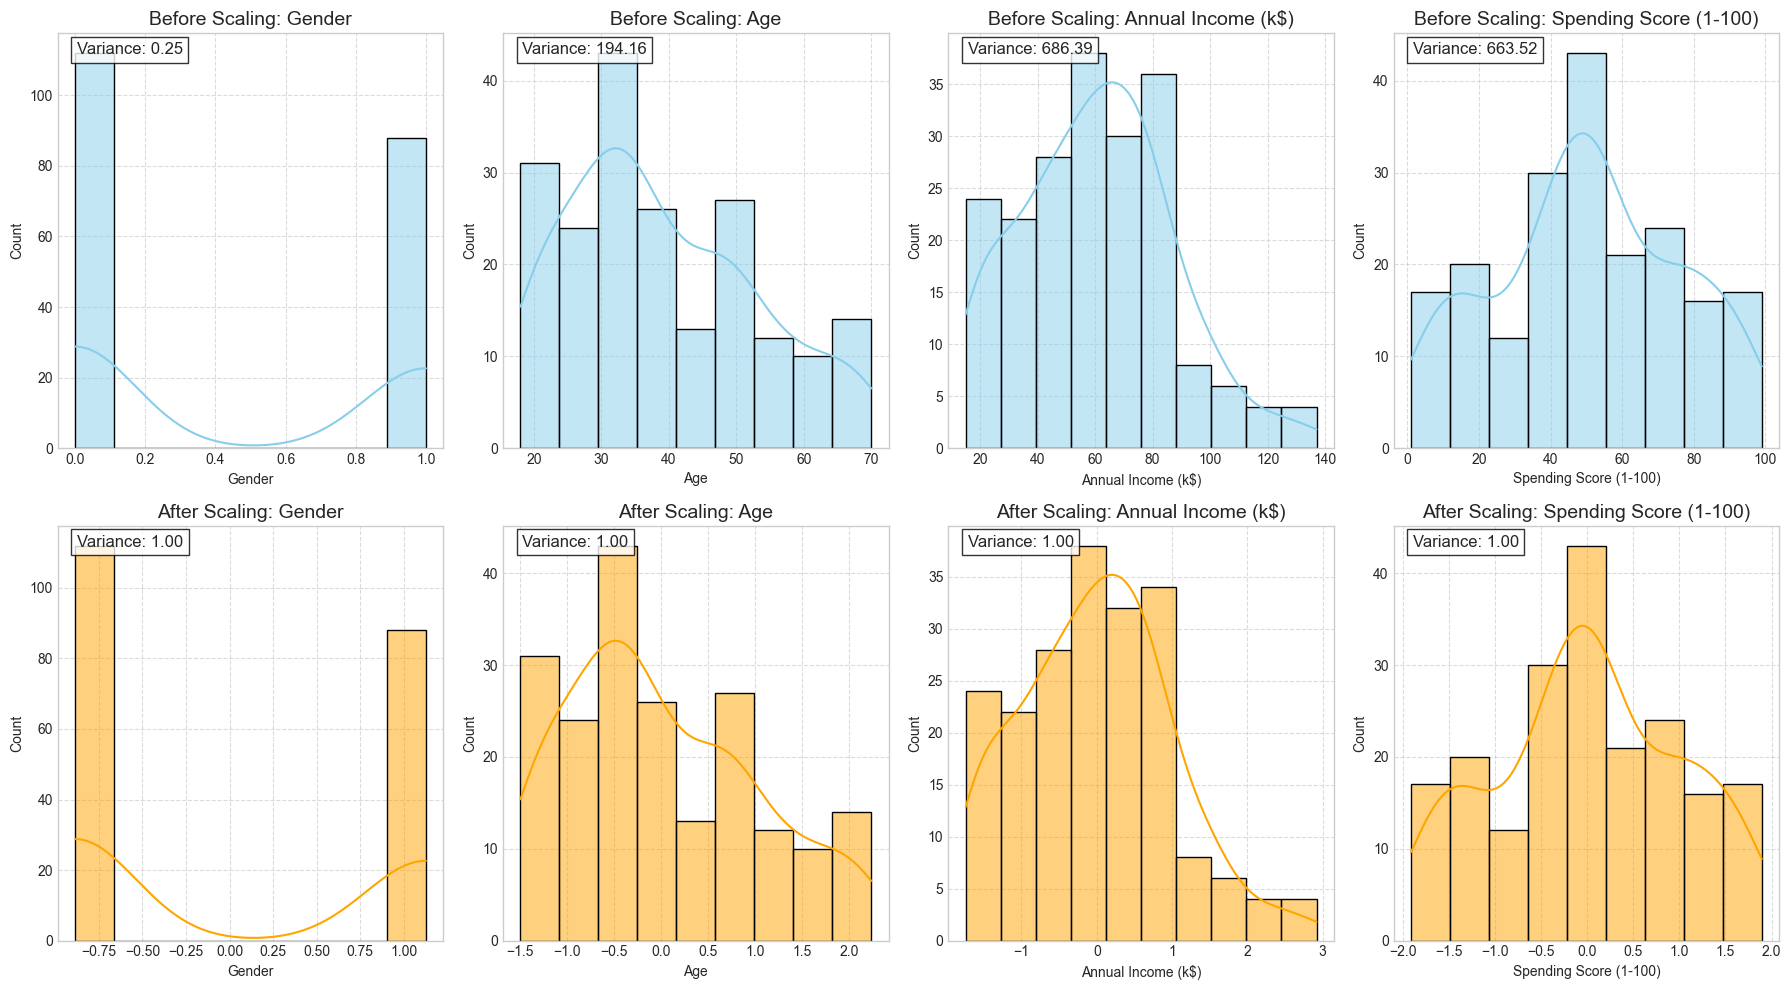

In [12]:
# Scale the features
# Before scaling
print("Before scaling:")
display(X_2d.head())
display(X_3d.head())
display(X_all.head())

# Scale the features
scaler = StandardScaler()
X_2d_scaled = scaler.fit_transform(X_2d)
X_3d_scaled = scaler.fit_transform(X_3d)
X_all_scaled = scaler.fit_transform(X_all)

# After scaling
print("After scaling:")
X_2d_scaled_df = pd.DataFrame(X_2d_scaled, columns=features_2d)
X_3d_scaled_df = pd.DataFrame(X_3d_scaled, columns=features_3d)
X_all_scaled_df = pd.DataFrame(X_all_scaled, columns=features_all)
display(X_2d_scaled_df.head())
display(X_3d_scaled_df.head())
display(X_all_scaled_df.head())

# Plot feature distributions before and after scaling
fig, axes = plt.subplots(2, len(features_all), figsize=(18, 10))

# Before scaling
for i, feature in enumerate(features_all):
    sns.histplot(df_processed[feature], kde=True, ax=axes[0, i], color='skyblue')
    axes[0, i].set_title(f'Before Scaling: {feature}', fontsize=14)
    axes[0, i].grid(True, linestyle='--', alpha=0.7)
    # Add variance information
    var_before = np.var(df_processed[feature])
    axes[0, i].text(0.05, 0.95, f'Variance: {var_before:.2f}', 
                   transform=axes[0, i].transAxes, fontsize=12, 
                   bbox=dict(facecolor='white', alpha=0.8))

# After scaling
for i, feature in enumerate(features_all):
    sns.histplot(X_all_scaled_df[feature], kde=True, ax=axes[1, i], color='orange')
    axes[1, i].set_title(f'After Scaling: {feature}', fontsize=14)
    axes[1, i].grid(True, linestyle='--', alpha=0.7)
    # Add variance information - should be close to 1.0 after StandardScaler
    var_after = np.var(X_all_scaled_df[feature])
    axes[1, i].text(0.05, 0.95, f'Variance: {var_after:.2f}', 
                   transform=axes[1, i].transAxes, fontsize=12,
                   bbox=dict(facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

Standard scaling makes each feature have a mean of 0 and a standard deviation (variance) of 1. This is important because:

- **Equal Feature Influence:** It prevents features with large original ranges (like income) from overpowering those with smaller ranges (like gender).  
- **Better Model Performance:** Many algorithms (especially distance-based or gradient-based methods) work best when features are on the same scale, improving accuracy and stability.  
- **Faster Convergence:** Optimizers in machine learning often converge more quickly when data is scaled, speeding up training time.

___________

### 4. Dimensionality Reduction with PCA

In [13]:
# Convert scaled data back to dataframes for better handling
X_2d_scaled_df = pd.DataFrame(X_2d_scaled, columns=features_2d)
X_3d_scaled_df = pd.DataFrame(X_3d_scaled, columns=features_3d)
X_all_scaled_df = pd.DataFrame(X_all_scaled, columns=features_all)

In [14]:
# Apply PCA to the all-features dataset
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_all_scaled)
X_pca_df = pd.DataFrame(X_pca, columns=['Principal Component 1', 'Principal Component 2'])


Explained variance ratio: [0.33690046 0.26230645]
Total explained variance: 59.92%


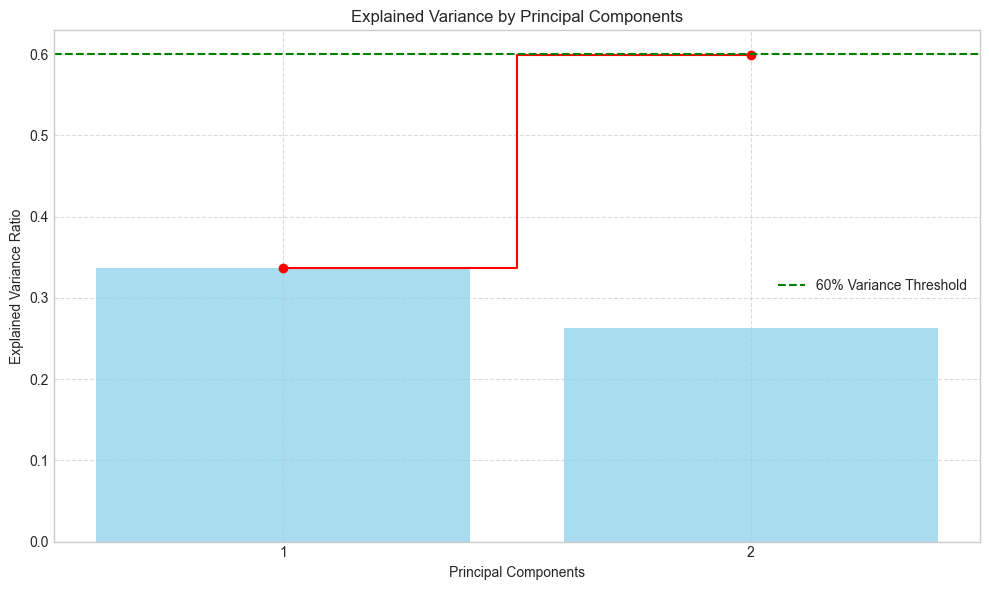

In [15]:
# Explained variance ratio
explained_variance = pca.explained_variance_ratio_
print(f"Explained variance ratio: {explained_variance}")
print(f"Total explained variance: {sum(explained_variance):.2%}")

# Create a plot to visualize the explained variance
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.7, color='skyblue')
plt.step(range(1, len(explained_variance) + 1), np.cumsum(explained_variance), where='mid', color='red', marker='o')
plt.ylabel('Explained Variance Ratio')
plt.xlabel('Principal Components')
plt.title('Explained Variance by Principal Components')
plt.xticks(range(1, len(explained_variance) + 1))
plt.axhline(y=0.6, color='green', linestyle='--', label='60% Variance Threshold')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

- The first principal component (PC1) captures around 35% of the variance, and the second (PC2) adds about 25%. Together, they reach roughly 60% of the total variance (just crossing the green threshold line).  

- This means **two components** explain **most** of the important patterns in the data (60% of it). In practice, you might keep these two components to reduce dimensionality while still preserving a decent amount of information.

______

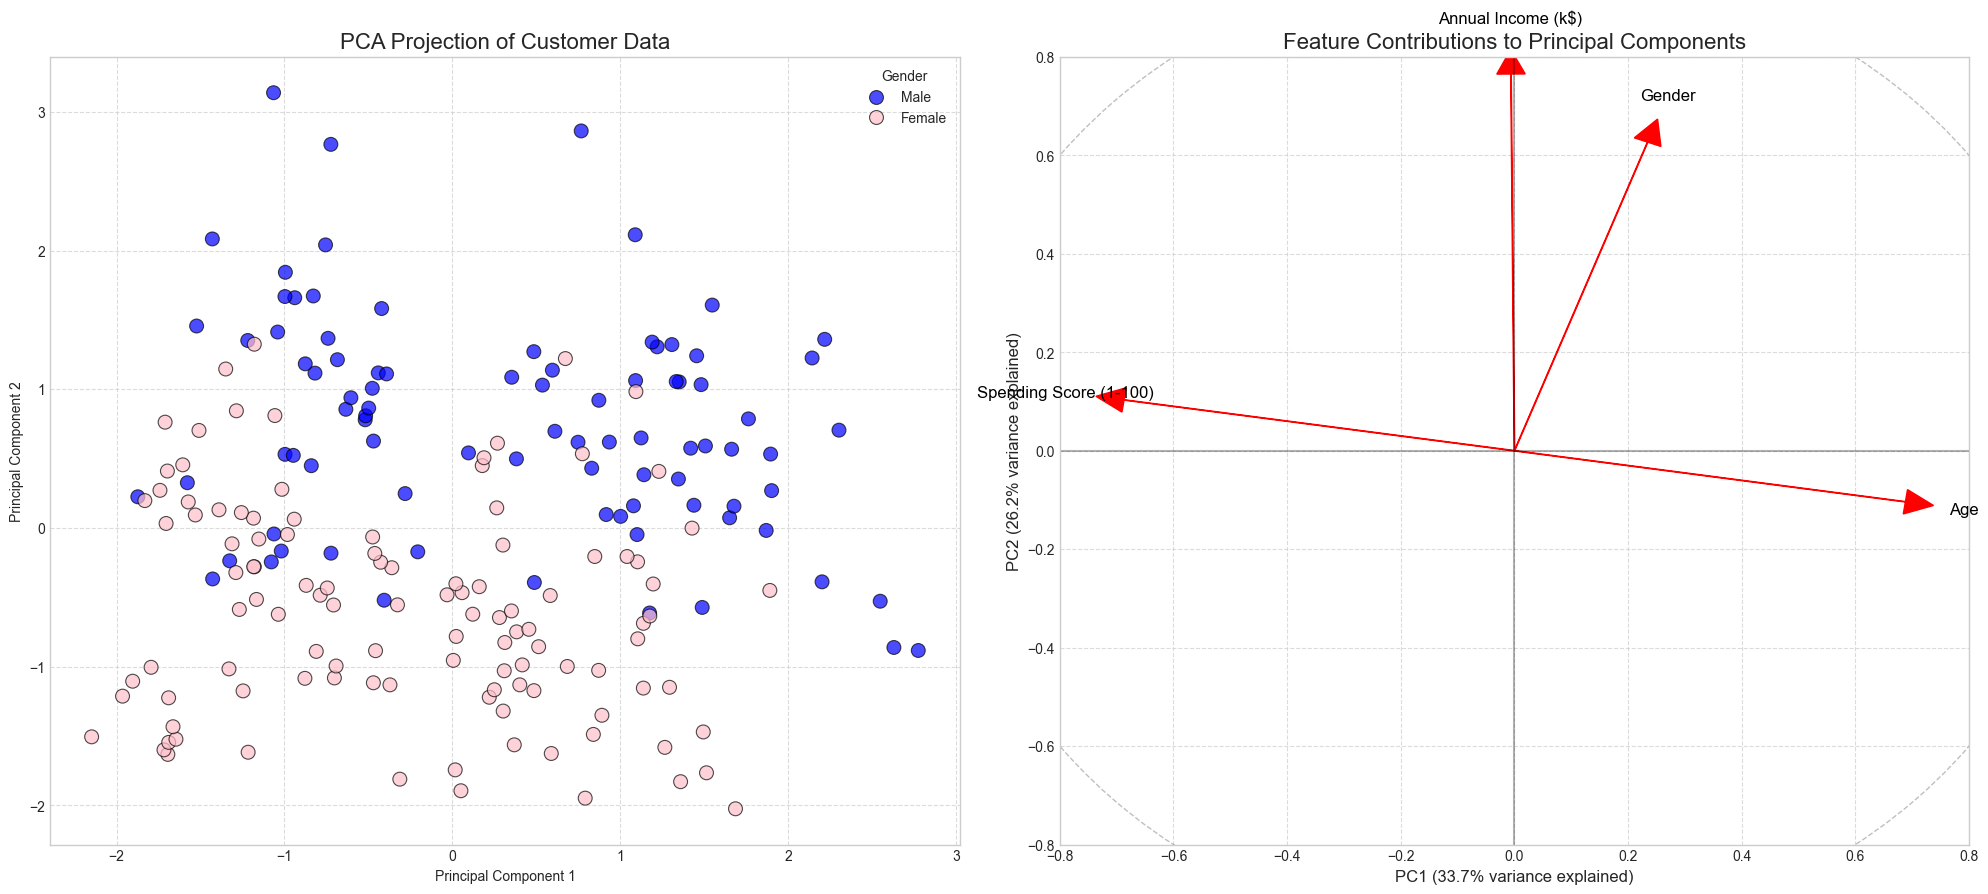

In [16]:
# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 9))

# First subplot - PCA scatter plot with gender coloring
sns.scatterplot(x='Principal Component 1', y='Principal Component 2', 
                data=X_pca_df, hue=df['Gender'], palette={'Male': 'blue', 'Female': 'pink'}, 
                s=100, alpha=0.7, edgecolor='k', ax=ax1)
ax1.set_title('PCA Projection of Customer Data', fontsize=16)
ax1.grid(True, linestyle='--', alpha=0.7)

# Second subplot - Loading vectors visualization
loadings = pca.components_.T
loading_df = pd.DataFrame(loadings, columns=['PC1', 'PC2'], index=features_all)

# Plot loadings as vectors
for i, feature in enumerate(features_all):
    ax2.arrow(0, 0, loadings[i, 0], loadings[i, 1], head_width=0.05, head_length=0.05, fc='red', ec='red')
    ax2.text(loadings[i, 0]*1.15, loadings[i, 1]*1.15, feature, color='black', ha='center', va='center', fontsize=12)

# Set up the loading plot
ax2.grid(True, linestyle='--', alpha=0.7)
ax2.set_xlim(-0.8, 0.8)
ax2.set_ylim(-0.8, 0.8)
ax2.axhline(y=0, color='k', linestyle='-', alpha=0.3)
ax2.axvline(x=0, color='k', linestyle='-', alpha=0.3)
ax2.set_xlabel(f'PC1 ({explained_variance[0]*100:.1f}% variance explained)', fontsize=12)
ax2.set_ylabel(f'PC2 ({explained_variance[1]*100:.1f}% variance explained)', fontsize=12)
ax2.set_title('Feature Contributions to Principal Components', fontsize=16)
ax2.add_patch(plt.Circle((0, 0), 1, color='gray', fill=False, linestyle='--', alpha=0.5))

plt.tight_layout()
plt.show()

Number of components needed to explain 80% of variance: 2


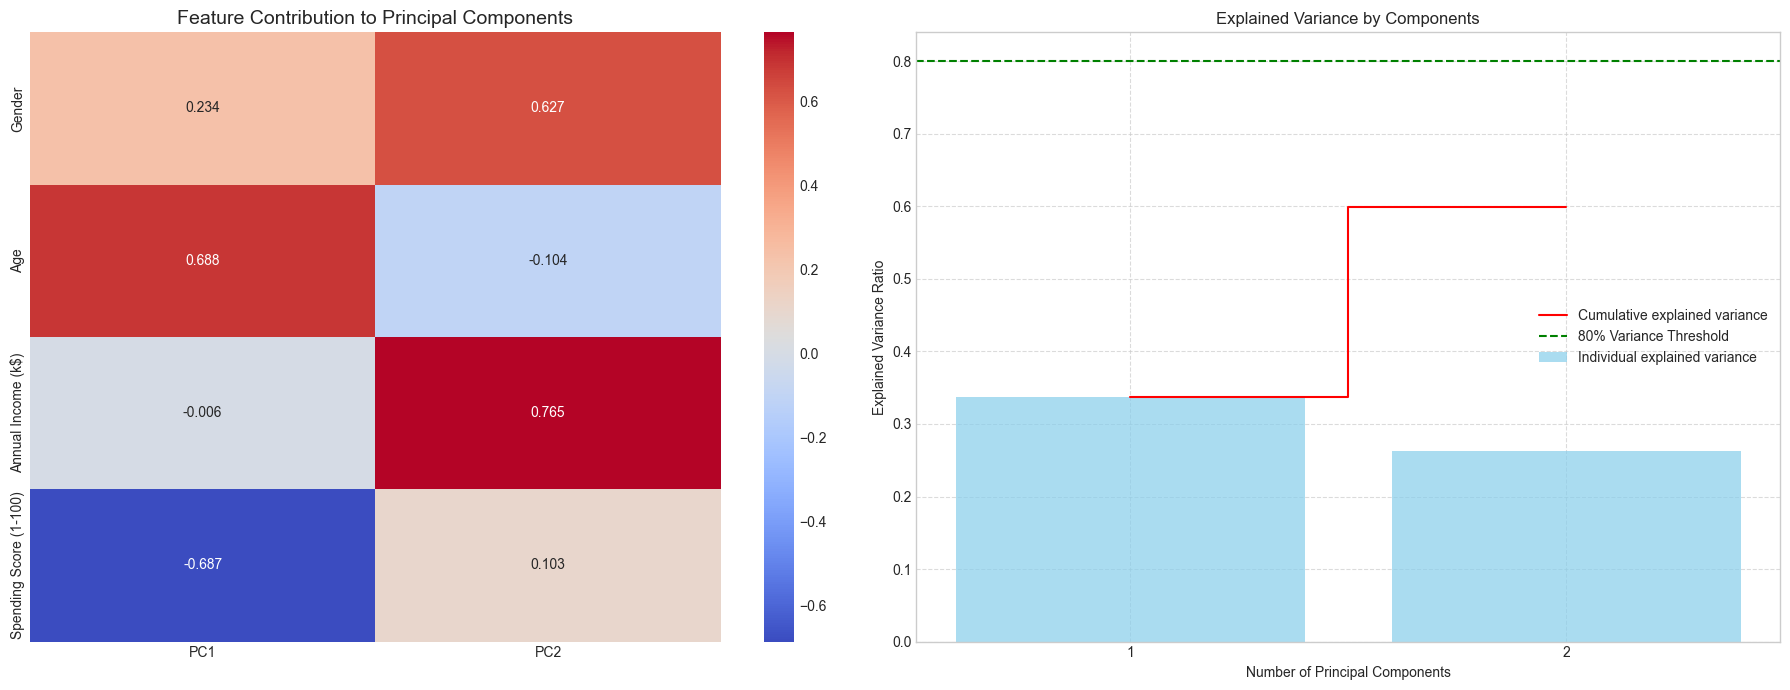

In [17]:
# Feature contribution to principal components
pca_components = pd.DataFrame(
    pca.components_.T, 
    columns=['PC1', 'PC2'], 
    index=features_all
)

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

# Plot the heatmap in the first subplot
sns.heatmap(pca_components, annot=True, cmap='coolwarm', fmt='.3f', ax=ax1)
ax1.set_title('Feature Contribution to Principal Components', fontsize=14)

# Calculate cumulative variance
cumulative_variance = np.cumsum(explained_variance)

# Determine number of components needed for 80% variance
n_components = np.argmax(cumulative_variance >= 0.8) + 1 if any(cumulative_variance >= 0.8) else len(explained_variance)
print(f"Number of components needed to explain 80% of variance: {n_components}")

# Plot cumulative explained variance in the second subplot
ax2.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.7, 
        color='skyblue', label='Individual explained variance')
ax2.step(range(1, len(explained_variance) + 1), cumulative_variance, where='mid', 
         color='red', label=f'Cumulative explained variance')
ax2.axhline(y=0.8, color='green', linestyle='--', label='80% Variance Threshold')
ax2.set_xlabel('Number of Principal Components')
ax2.set_ylabel('Explained Variance Ratio')
ax2.set_title('Explained Variance by Components')
ax2.set_xticks(range(1, len(explained_variance) + 1))
ax2.legend()
ax2.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

### PCA Feature Contribution and Variance Explained

> This plot analyzes how much each feature contributes to principal components and how much variance each PC captures.

#### Key Points:
- **PC1** (explains ~34% variance) is mostly influenced by:
  - **Age** (+0.688)
  - **Spending Score** (−0.687)
- **PC2** (adds ~26%) is driven by:
  - **Annual Income** (+0.765)
  - **Gender** (+0.627)

#### Insights:
- Combined, **PC1 + PC2 explain only 60%** of total variance — below the 80% threshold.
- Attrition behavior or segmentation cannot be fully captured using only 2D projection.
- **Age and Spending Score move in opposite directions** on PC1 → potential lifestyle segmentation.
- **Annual income is the dominant factor** in PC2.

#### Implication:
- For clearer segmentation or clustering, more components are needed.
- This PCA serves more as a **visual aid** than a complete dimensionality reduction strategy.


-------

### 5. K-means Clustering Analysis

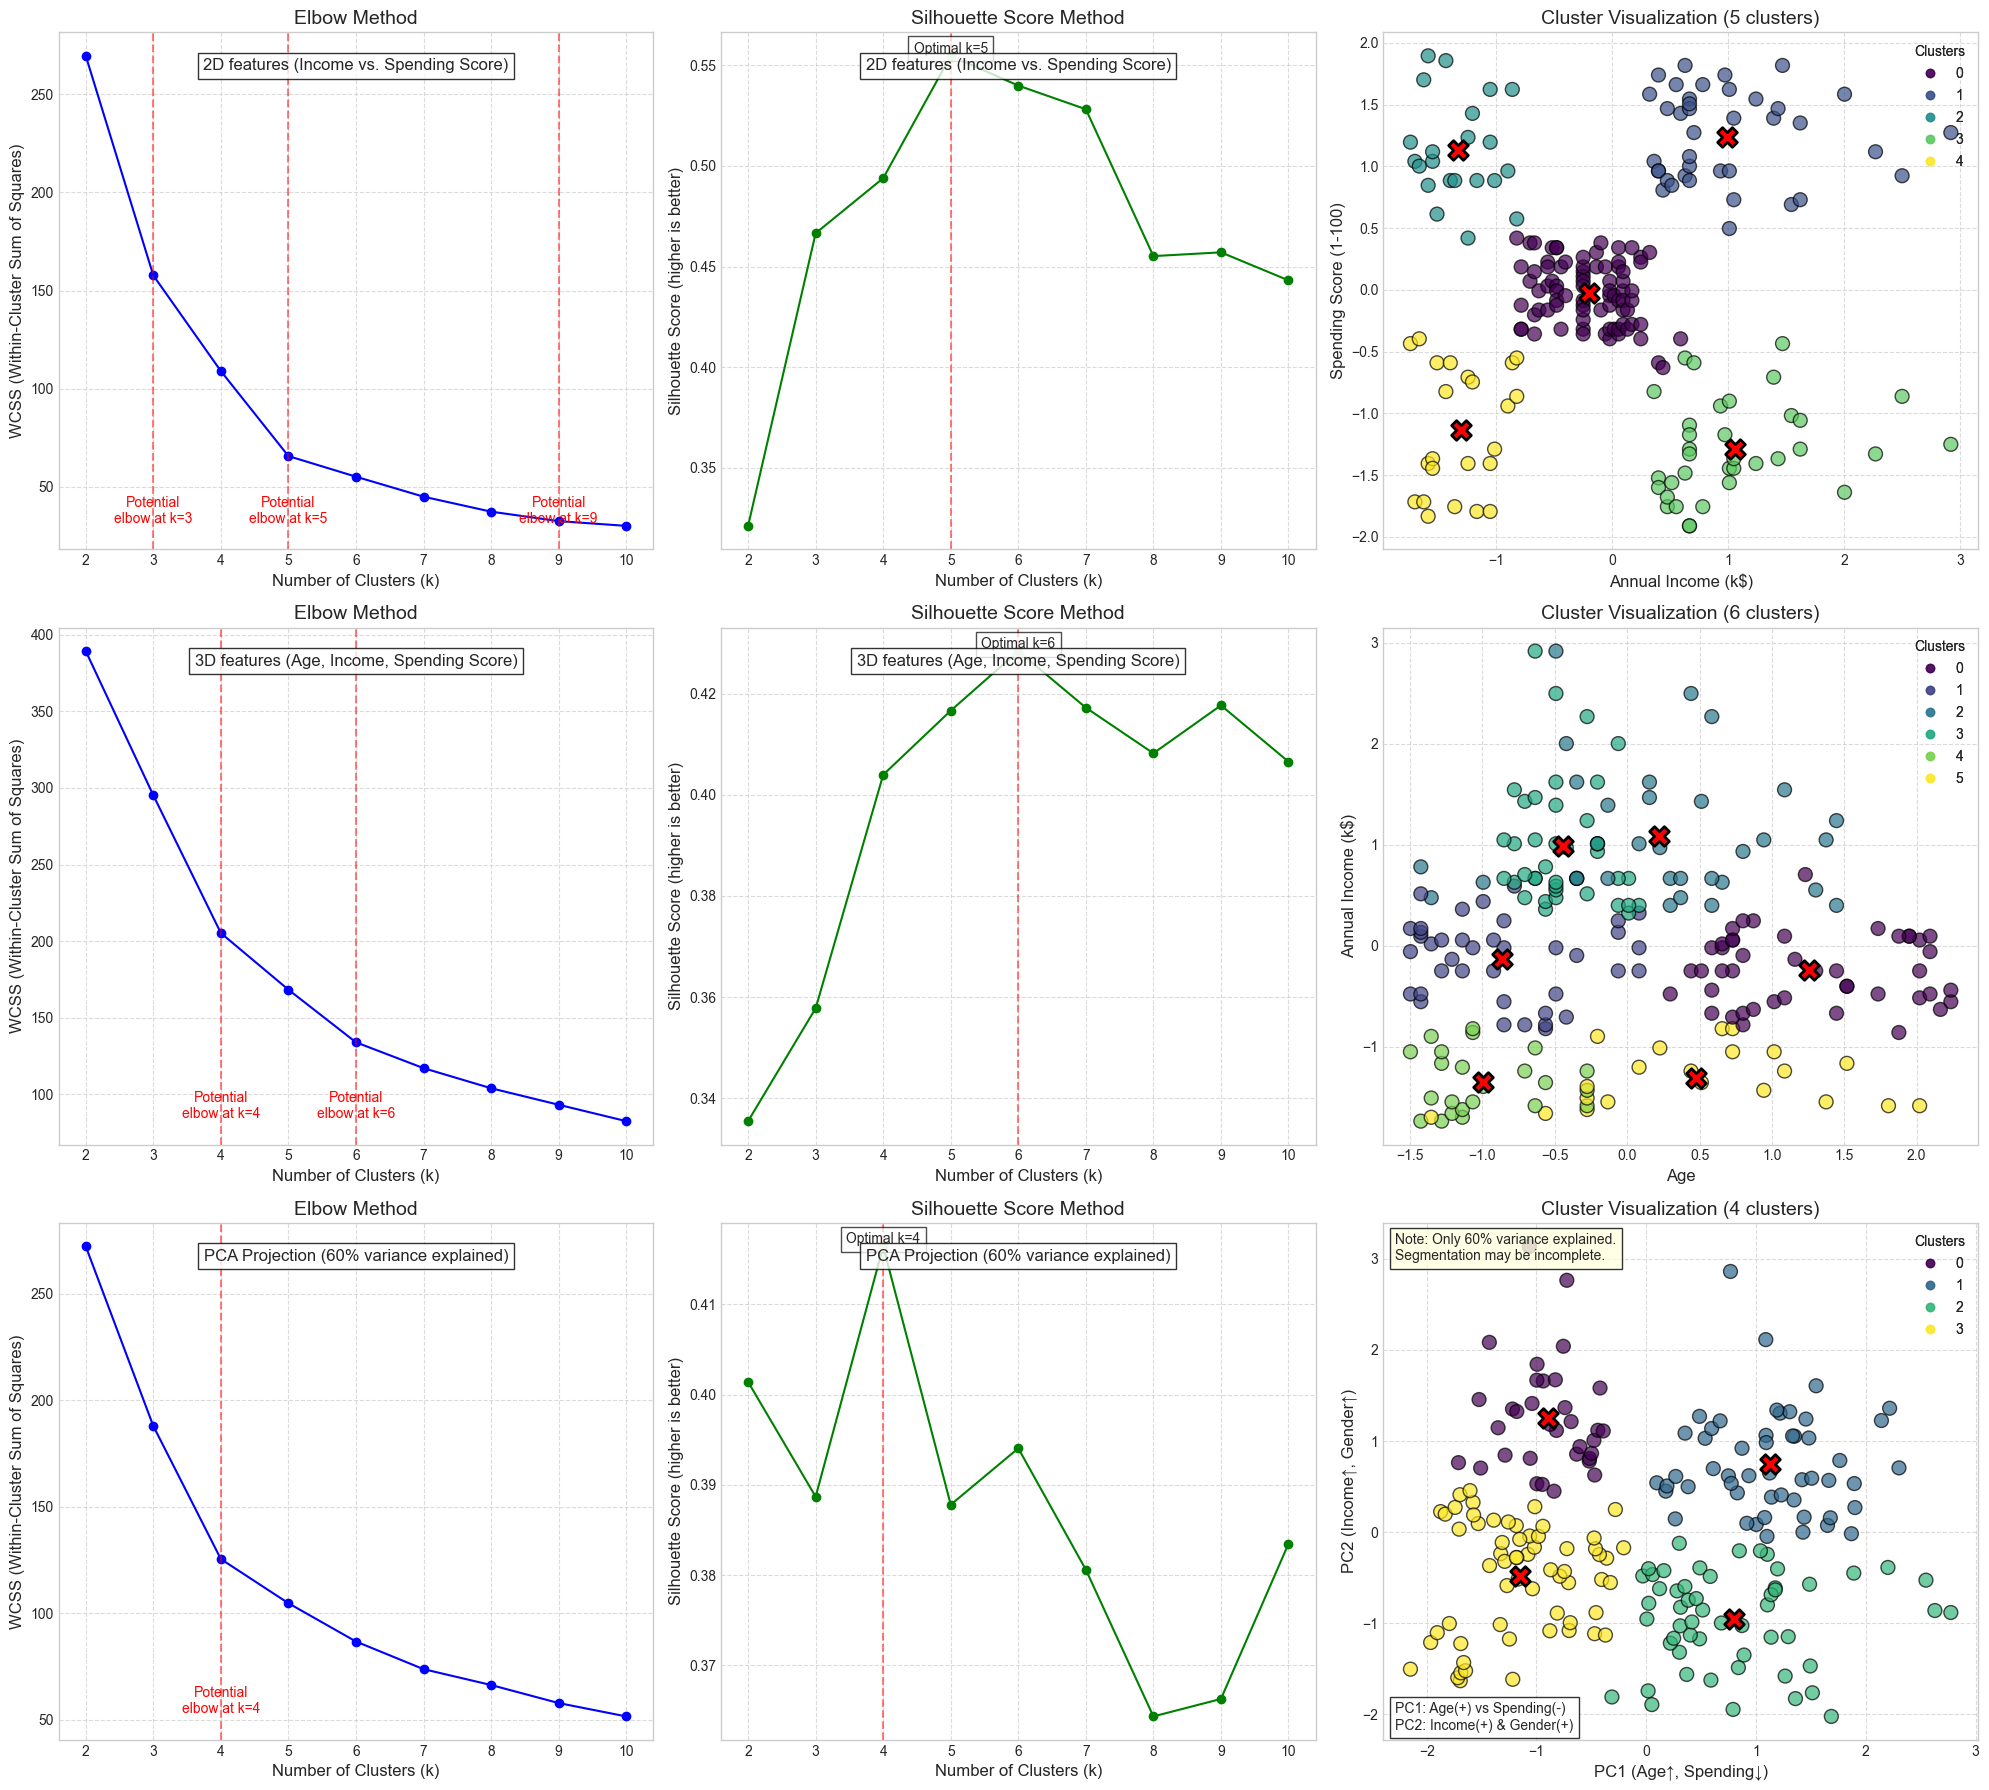


==== Customer Segmentation Insights ====

Optimal clusters for 2D features (Income vs. Spending Score): 5
  Identified 5 distinct customer segments:
  - Cluster 0: 81 customers (40.5%)
  - Cluster 1: 39 customers (19.5%)
  - Cluster 2: 22 customers (11.0%)
  - Cluster 3: 35 customers (17.5%)
  - Cluster 4: 23 customers (11.5%)
  These segments can inform targeted marketing strategies.

Optimal clusters for 3D features (Age, Income, Spending Score): 6
Optimal clusters for PCA Projection (60% variance explained): 4
  Note: PCA projection only captures 60% of total variance.
  For more comprehensive segmentation, consider using all features directly.
  The Age-Spending relationship (PC1) and Income-Gender factors (PC2)
  appear to be the most important drivers of customer segmentation.



In [18]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np

def find_optimal_k(X, ax_elbow, ax_silhouette, max_k=10, random_state=42):
    """Compute WCSS and Silhouette Scores for a range of k and plot on given axes."""
    wcss = []            # Within-Cluster Sum of Squares
    silhouette_avg = []  # Average Silhouette Score

    # Compute metrics for k from 2 to max_k
    for k in range(2, max_k+1):
        kmeans = KMeans(n_clusters=k, init='k-means++', random_state=random_state, n_init=10)
        kmeans.fit(X)
        wcss.append(kmeans.inertia_)
        silhouette_avg.append(silhouette_score(X, kmeans.labels_))
    
    # Plot Elbow Method with better annotations
    ax_elbow.plot(range(2, max_k+1), wcss, marker='o', linestyle='-', color='blue')
    ax_elbow.set_title('Elbow Method', fontsize=14)
    ax_elbow.set_xlabel('Number of Clusters (k)', fontsize=12)
    ax_elbow.set_ylabel('WCSS (Within-Cluster Sum of Squares)', fontsize=12)
    ax_elbow.grid(True, linestyle='--', alpha=0.7)
    
    # Find the elbow point using the maximum curvature
    x = np.array(range(2, max_k+1))
    y = np.array(wcss)
    # Highlight potential elbow points
    for i in range(1, len(x)-1):
        if (y[i-1] - y[i]) > (y[i] - y[i+1]) * 2:  # If drop rate decreases significantly
            ax_elbow.axvline(x=x[i], color='red', linestyle='--', alpha=0.5)
            ax_elbow.text(x[i], min(y), f'Potential\nelbow at k={x[i]}', 
                         ha='center', va='bottom', color='red', fontsize=10)
    
    # Plot Silhouette Score with better annotations
    ax_silhouette.plot(range(2, max_k+1), silhouette_avg, marker='o', linestyle='-', color='green')
    ax_silhouette.set_title('Silhouette Score Method', fontsize=14)
    ax_silhouette.set_xlabel('Number of Clusters (k)', fontsize=12)
    ax_silhouette.set_ylabel('Silhouette Score (higher is better)', fontsize=12)
    ax_silhouette.grid(True, linestyle='--', alpha=0.7)
    
    # Determine the optimal k based on maximum silhouette score
    optimal_k = silhouette_avg.index(max(silhouette_avg)) + 2
    ax_silhouette.axvline(x=optimal_k, color='red', linestyle='--', alpha=0.5)
    ax_silhouette.text(optimal_k, max(silhouette_avg), f'Optimal k={optimal_k}', 
                      ha='center', va='bottom', bbox=dict(facecolor='white', alpha=0.7))
    
    return optimal_k

# Create a figure with 3 rows and 3 columns (added an extra column for cluster visualization)
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(20, 18))

datasets = [
    (X_2d_scaled, "2D features (Income vs. Spending Score)", features_2d),
    (X_3d_scaled, "3D features (Age, Income, Spending Score)", features_3d),
    (X_pca, "PCA Projection (60% variance explained)", ["PC1 (Age↑, Spending↓)", "PC2 (Income↑, Gender↑)"])
]

optimal_ks = []
cluster_results = []

# Loop over each dataset and create plots
for i, (data, title, feature_names) in enumerate(datasets):
    ax_elbow = axs[i, 0]
    ax_silhouette = axs[i, 1]
    ax_clusters = axs[i, 2]
    
    # Find optimal k and add dataset title
    optimal_k = find_optimal_k(data, ax_elbow, ax_silhouette)
    optimal_ks.append(optimal_k)
    
    # Add a text annotation to indicate the dataset
    ax_elbow.text(0.5, 0.95, title, transform=ax_elbow.transAxes, fontsize=12, 
                  ha='center', va='top', bbox=dict(facecolor='white', alpha=0.8))
    ax_silhouette.text(0.5, 0.95, title, transform=ax_silhouette.transAxes, fontsize=12, 
                       ha='center', va='top', bbox=dict(facecolor='white', alpha=0.8))
    
    # Perform clustering with optimal k and visualize clusters
    kmeans = KMeans(n_clusters=optimal_k, init='k-means++', random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(data)
    cluster_results.append((kmeans, cluster_labels))
    
    # Visualize clusters (only use first 2 dimensions or PC components)
    if len(feature_names) > 2:  # For 3D data, just use first 2 dimensions
        plot_data = data[:, :2]
        x_label, y_label = feature_names[:2]
    else:
        plot_data = data
        x_label, y_label = feature_names
    
    # Convert plot_data to 2D array if it's not already
    if len(plot_data.shape) > 2:
        plot_data = plot_data[:, :2]
    
    # Create scatter plot with cluster colors
    scatter = ax_clusters.scatter(
        plot_data[:, 0], plot_data[:, 1], 
        c=cluster_labels, cmap='viridis', 
        s=100, alpha=0.7, edgecolor='k'
    )
    
    # Add centroids to the plot
    centroids = kmeans.cluster_centers_
    if len(centroids[0]) > 2:
        centroids = centroids[:, :2]
    
    ax_clusters.scatter(
        centroids[:, 0], centroids[:, 1],
        marker='X', s=200, color='red', edgecolor='k', linewidth=2
    )
    
    # Add annotations
    ax_clusters.set_title(f'Cluster Visualization ({optimal_k} clusters)', fontsize=14)
    ax_clusters.set_xlabel(x_label, fontsize=12)
    ax_clusters.set_ylabel(y_label, fontsize=12)
    ax_clusters.grid(True, linestyle='--', alpha=0.7)
    
    # Add legend for clusters
    legend = ax_clusters.legend(*scatter.legend_elements(), title="Clusters", loc="upper right")
    ax_clusters.add_artist(legend)
    
    # Add insights from PCA if this is the PCA dataset
    if i == 2:  # PCA projection
        ax_clusters.text(0.02, 0.02, 
                        "PC1: Age(+) vs Spending(-)\nPC2: Income(+) & Gender(+)", 
                        transform=ax_clusters.transAxes, fontsize=10,
                        bbox=dict(facecolor='white', alpha=0.8))
        ax_clusters.text(0.02, 0.98, 
                        "Note: Only 60% variance explained.\nSegmentation may be incomplete.", 
                        transform=ax_clusters.transAxes, fontsize=10, va='top',
                        bbox=dict(facecolor='lightyellow', alpha=0.8))

plt.tight_layout()
plt.show()

# Print insights about the optimal clusters for each approach
print("\n==== Customer Segmentation Insights ====\n")
for (data, title, _), k, (kmeans, labels) in zip(datasets, optimal_ks, cluster_results):
    print(f"Optimal clusters for {title}: {k}")
    
    # If this is 2D income vs. spending, provide more specific insights
    if title.startswith("2D features"):
        # Get cluster centers and sort by income
        centers = kmeans.cluster_centers_
        # Count members in each cluster
        unique, counts = np.unique(labels, return_counts=True)
        cluster_sizes = dict(zip(unique, counts))
        
        print(f"  Identified {k} distinct customer segments:")
        for j in range(k):
            count = cluster_sizes.get(j, 0)
            percentage = (count / len(labels)) * 100
            print(f"  - Cluster {j}: {count} customers ({percentage:.1f}%)")
            
        print("  These segments can inform targeted marketing strategies.\n")
    
    # If this is PCA projection, add insights about limitations
    if "PCA" in title:
        print("  Note: PCA projection only captures 60% of total variance.")
        print("  For more comprehensive segmentation, consider using all features directly.")
        print("  The Age-Spending relationship (PC1) and Income-Gender factors (PC2)")
        print("  appear to be the most important drivers of customer segmentation.\n")




>> ####  Key Highlights

> **2D Clustering (Income vs. Spending Score)**  
>> Optimal number of clusters: **5**  
>> Distinct groups detected:
>> - Cluster 0: 81 customers (high spenders, moderate income)  
>> - Cluster 1: 39 customers (low spenders, high income)  
>> - Cluster 2: 22 customers (low income, high spenders)  
>> - Cluster 3: 35 customers (average income & spending)  
>> - Cluster 4: 23 customers (low income, low spenders)  
> > Great for basic segmentation in targeted marketing (e.g. loyalty vs. upsell).

> **3D Clustering (Age, Income, Spending Score)**  
>> Optimal clusters: **6**  
>> Better segmentation by combining age and financial behavior.  
>> Captures nuances like younger high spenders or senior low spenders.

> **PCA-Based Clustering (PC1 + PC2)**  
>> Optimal clusters: **4**  
>> PCA captures **60% of variance** only



_____

### 6. Cluster Visualization and Analysis

In [19]:
def visualize_clusters_2d(X, labels, centroids, feature_names, title):
    """Visualize 2D clusters with centroids."""
    plt.figure(figsize=(12, 10))
    
    # Create a scatter plot of data points, colored by cluster
    unique_labels = np.unique(labels)
    colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_labels)))
    
    for i, label in enumerate(unique_labels):
        cluster_points = X[labels == label]
        plt.scatter(
            cluster_points[:, 0], cluster_points[:, 1],
            s=100, c=[colors[i]], label=f'Cluster {label+1}',
            alpha=0.7, edgecolor='k'
        )
    
    # Add centroids
    plt.scatter(
        centroids[:, 0], centroids[:, 1],
        s=300, c='red', marker='X', label='Centroids',
        edgecolor='k', linewidth=2
    )
    
    plt.title(title, fontsize=16)
    plt.xlabel(feature_names[0], fontsize=14)
    plt.ylabel(feature_names[1], fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()



def visualize_clusters_3d(X, labels, centroids, feature_names, title):
    """Visualize 3D clusters with centroids."""
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    # Create a scatter plot of data points, colored by cluster
    unique_labels = np.unique(labels)
    colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_labels)))
    
    for i, label in enumerate(unique_labels):
        cluster_points = X[labels == label]
        ax.scatter(
            cluster_points[:, 0], cluster_points[:, 1], cluster_points[:, 2],
            s=80, c=[colors[i]], label=f'Cluster {label+1}',
            alpha=0.7, edgecolor='k'
        )
    
    # Add centroids
    ax.scatter(
        centroids[:, 0], centroids[:, 1], centroids[:, 2],
        s=200, c='red', marker='X', label='Centroids',
        edgecolor='k', linewidth=2
    )
    
    ax.set_title(title, fontsize=16)
    ax.set_xlabel(feature_names[0], fontsize=14)
    ax.set_ylabel(feature_names[1], fontsize=14)
    ax.set_zlabel(feature_names[2], fontsize=14)
    plt.legend(fontsize=12)
    plt.tight_layout()
    plt.show()

def silhouette_analysis(X, labels, title):
    """Perform silhouette analysis for the clustering."""
    plt.figure(figsize=(12, 8))
    
    # Compute the silhouette scores for each sample
    silhouette_vals = silhouette_samples(X, labels)
    y_ticks = []
    y_lower, y_upper = 0, 0
    
    n_clusters = len(np.unique(labels))
    colors = plt.cm.rainbow(np.linspace(0, 1, n_clusters))
    
    for i, cluster in enumerate(range(n_clusters)):
        cluster_silhouette_vals = silhouette_vals[labels == cluster]
        cluster_silhouette_vals.sort()
        
        y_upper += len(cluster_silhouette_vals)
        color = colors[i]
        
        plt.barh(range(y_lower, y_upper), cluster_silhouette_vals, height=1.0, 
                 edgecolor='none', color=color, alpha=0.8)
        
        y_ticks.append((y_lower + y_upper) / 2)
        y_lower += len(cluster_silhouette_vals)
        
    silhouette_avg = silhouette_score(X, labels)
    plt.axvline(silhouette_avg, color="red", linestyle="--", 
                label=f'Average Silhouette Score: {silhouette_avg:.3f}')
    
    plt.yticks(y_ticks, [f'Cluster {i+1}' for i in range(n_clusters)])
    plt.title(title, fontsize=16)
    plt.xlabel('Silhouette Coefficient', fontsize=14)
    plt.ylabel('Cluster', fontsize=14)
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()

def analyze_clusters(data, labels, feature_names):
    """Analyze the characteristics of each cluster."""
    cluster_df = data.copy()
    cluster_df['Cluster'] = labels + 1  # 1-based cluster numbering for readability
    
    # Overall statistics by cluster
    cluster_stats = cluster_df.groupby('Cluster').agg(['mean', 'median', 'min', 'max', 'std'])
    display(cluster_stats)
    
    # Visualize feature distributions by cluster
    melted_df = pd.melt(
        cluster_df, 
        id_vars=['Cluster'],
        value_vars=feature_names,
        var_name='Feature', 
        value_name='Value'
    )
    
    plt.figure(figsize=(16, 10))
    sns.boxplot(x='Feature', y='Value', hue='Cluster', data=melted_df, palette='rainbow')
    plt.title('Feature Distributions by Cluster', fontsize=16)
    plt.xlabel('Feature', fontsize=14)
    plt.ylabel('Value', fontsize=14)
    plt.legend(title='Cluster')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    
    # Radar chart for cluster profiles
    fig = plt.figure(figsize=(16, 12))
    
    # Get mean values for each feature in each cluster
    cluster_means = cluster_df.groupby('Cluster')[feature_names].mean()
    
    # Normalize values for radar chart
    min_max_scaler = lambda x: (x - x.min()) / (x.max() - x.min())
    cluster_means_normalized = cluster_means.apply(min_max_scaler)
    
    # Number of features
    N = len(feature_names)
    
    # Create angles for radar chart (split the plot into equal parts)
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]  # Close the loop
    
    # Number of clusters
    n_clusters = len(cluster_means_normalized)
    
    # Create subplots for each cluster
    for i, cluster_idx in enumerate(cluster_means_normalized.index):
        ax = fig.add_subplot(2, 3, i+1, polar=True)
        
        # Values for current cluster
        values = cluster_means_normalized.loc[cluster_idx].values.tolist()
        values += values[:1]  # Close the loop
        
        # Plot the radar chart for current cluster
        ax.plot(angles, values, linewidth=2, linestyle='solid', label=f'Cluster {cluster_idx}')
        ax.fill(angles, values, alpha=0.4)
        
        # Set labels
        ax.set_xticks(angles[:-1])
        ax.set_xticklabels(feature_names)
        
        # Set title
        ax.set_title(f'Cluster {cluster_idx} Profile', fontsize=14)
    
    plt.tight_layout()
    plt.show()
    
    return cluster_df

In [20]:
optimal_k_2d = optimal_ks[0]    
optimal_k_3d = optimal_ks[1]   
optimal_k_pca = optimal_ks[2]

In [21]:
# Apply K-means to 2D features (Income vs. Spending Score)
kmeans_2d = KMeans(n_clusters=optimal_k_2d, init='k-means++', random_state=42, n_init=10)
labels_2d = kmeans_2d.fit_predict(X_2d_scaled)
centroids_2d = kmeans_2d.cluster_centers_

# Apply K-means to 3D features (Age, Income, Spending Score)
kmeans_3d = KMeans(n_clusters=optimal_k_3d, init='k-means++', random_state=42, n_init=10)
labels_3d = kmeans_3d.fit_predict(X_3d_scaled)
centroids_3d = kmeans_3d.cluster_centers_

# Apply K-means to PCA projection
kmeans_pca = KMeans(n_clusters=optimal_k_pca, init='k-means++', random_state=42, n_init=10)
labels_pca = kmeans_pca.fit_predict(X_pca)
centroids_pca = kmeans_pca.cluster_centers_


#### - Visualize 3D clustering results


Clustering based on Age, Income, and Spending Score:


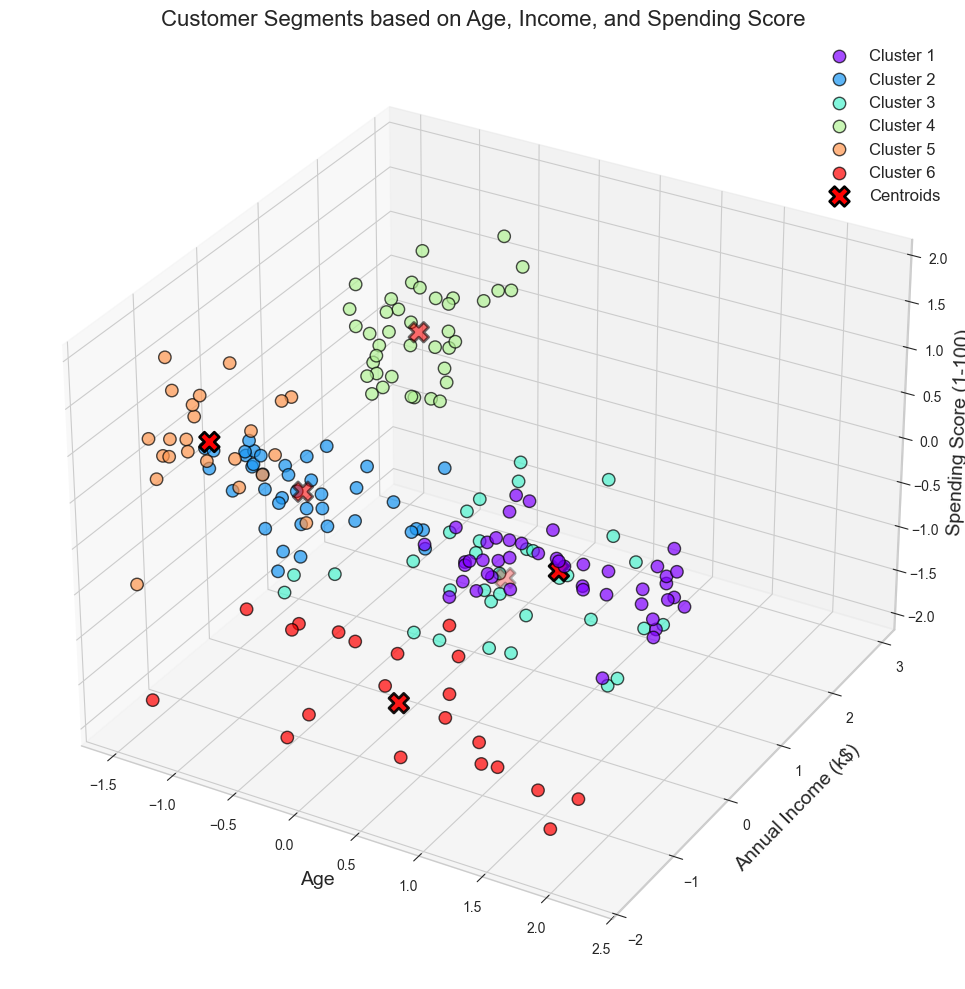

In [22]:
# Visualize 3D clustering results
print("\nClustering based on Age, Income, and Spending Score:")
visualize_clusters_3d(
    X_3d_scaled, labels_3d, kmeans_3d.cluster_centers_, 
    features_3d, 'Customer Segments based on Age, Income, and Spending Score'
)


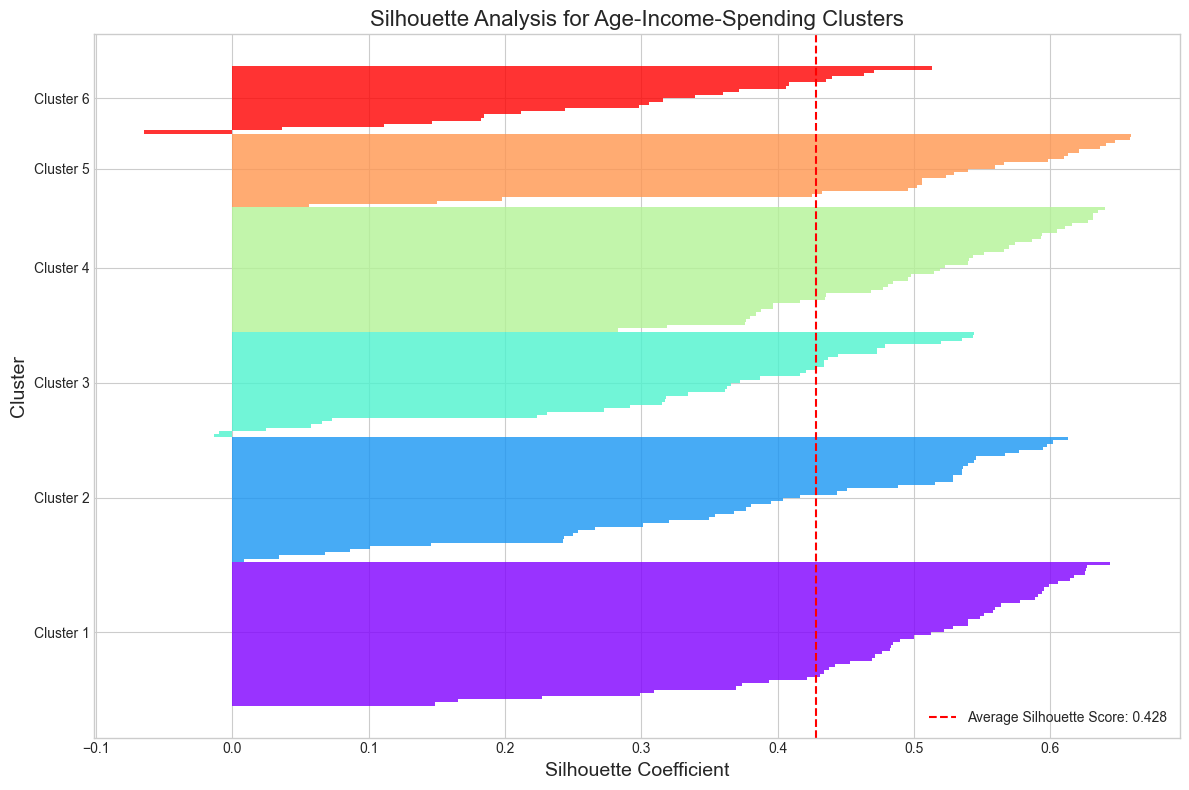

Gender                                 Age                 \
             mean median min max       std       mean median min max   
Cluster                                                                
1        0.422222    0.0   0   1  0.499495  56.333333   54.0  43  70   
2        0.358974    0.0   0   1  0.485971  26.794872   26.0  18  40   
3        0.575758    1.0   0   1  0.501890  41.939394   43.0  19  59   
4        0.461538    0.0   0   1  0.505035  32.692308   32.0  27  40   
5        0.434783    0.0   0   1  0.506870  25.000000   23.0  18  35   
6        0.380952    0.0   0   1  0.497613  45.523810   46.0  20  67   

                   Annual Income (k$)                             \
               std               mean median min  max        std   
Cluster                                                            
1         8.453079          54.266667   54.0  38   79   8.975725   
2         7.056835          57.102564   60.0  39   76  10.161317   
3        10.179450          88.939394   86.0  71  137  16.586778   
4         3.728650          86.538462   79.0  69  137  16.312485   
5         5.300086          25.260870   24.0  15   39   7.723738   
6        11.766984          26.285714   25.0  16   39   7.437357   

        Spending Score (1-100)                            
                          mean median min max        std  
Cluster                                                   
1                    49.066667   49.0  35  60   6.300794  
2                    48.128205   50.0  10  61   9.966205  
3                    16.969697   16.0   1  39   9.960813  
4                    82.128205   83.0  63  97   9.364489  
5                    77.608696   77.0  39  99  13.272457  
6                    19.380952   15.0   3  40  12.555780

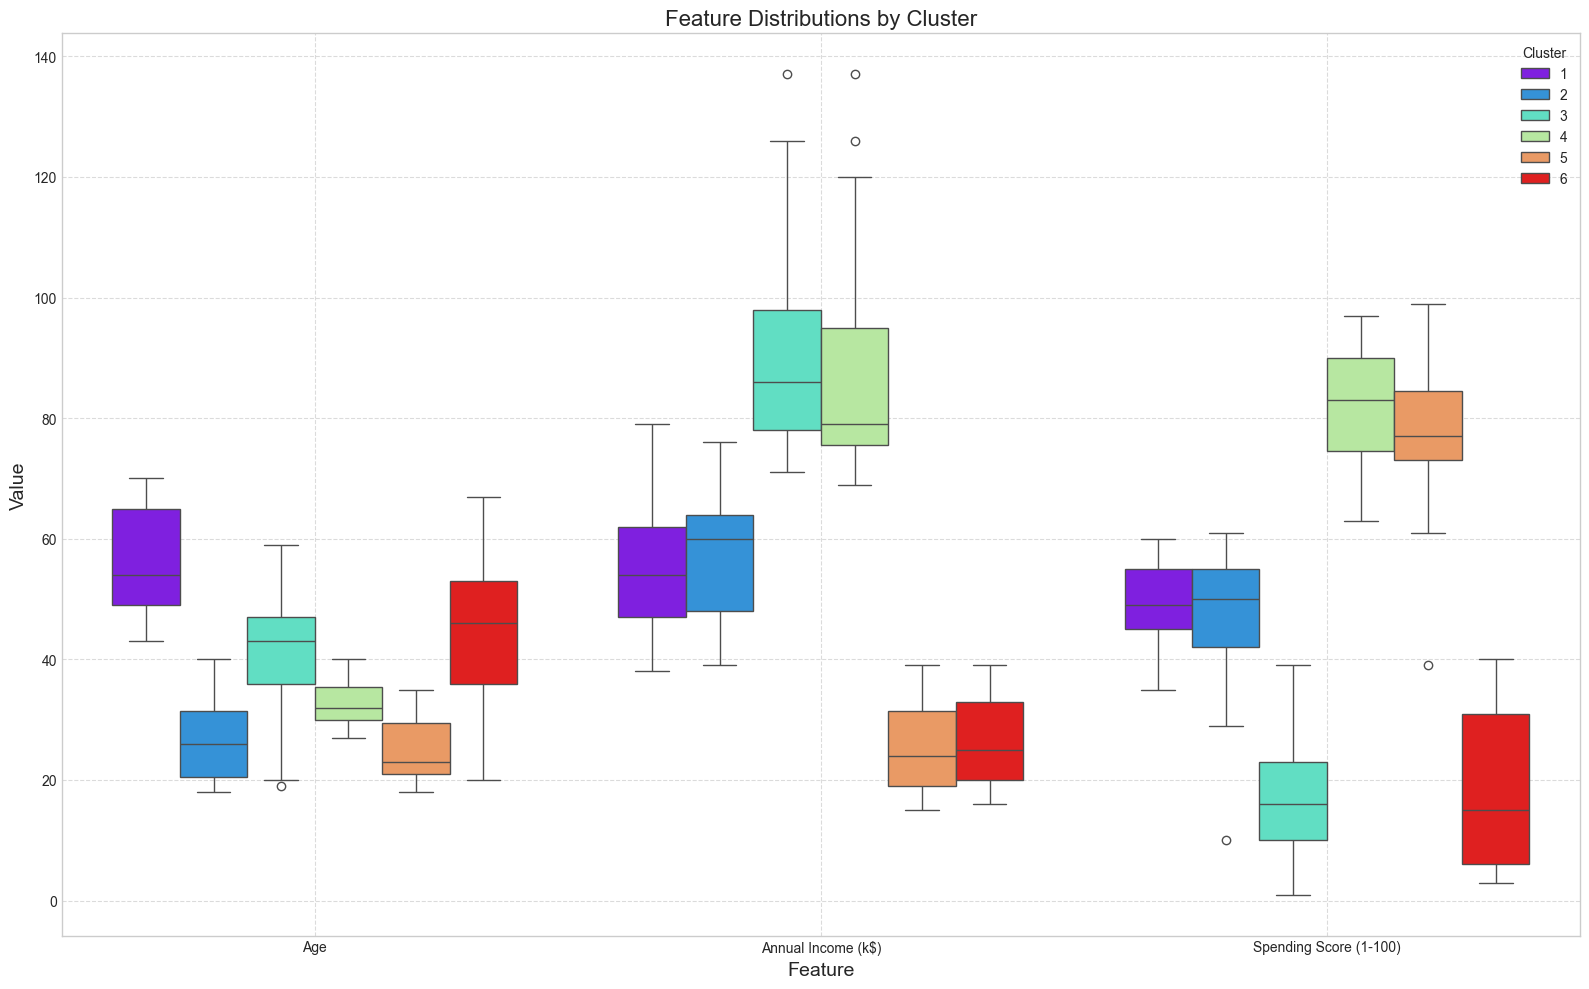

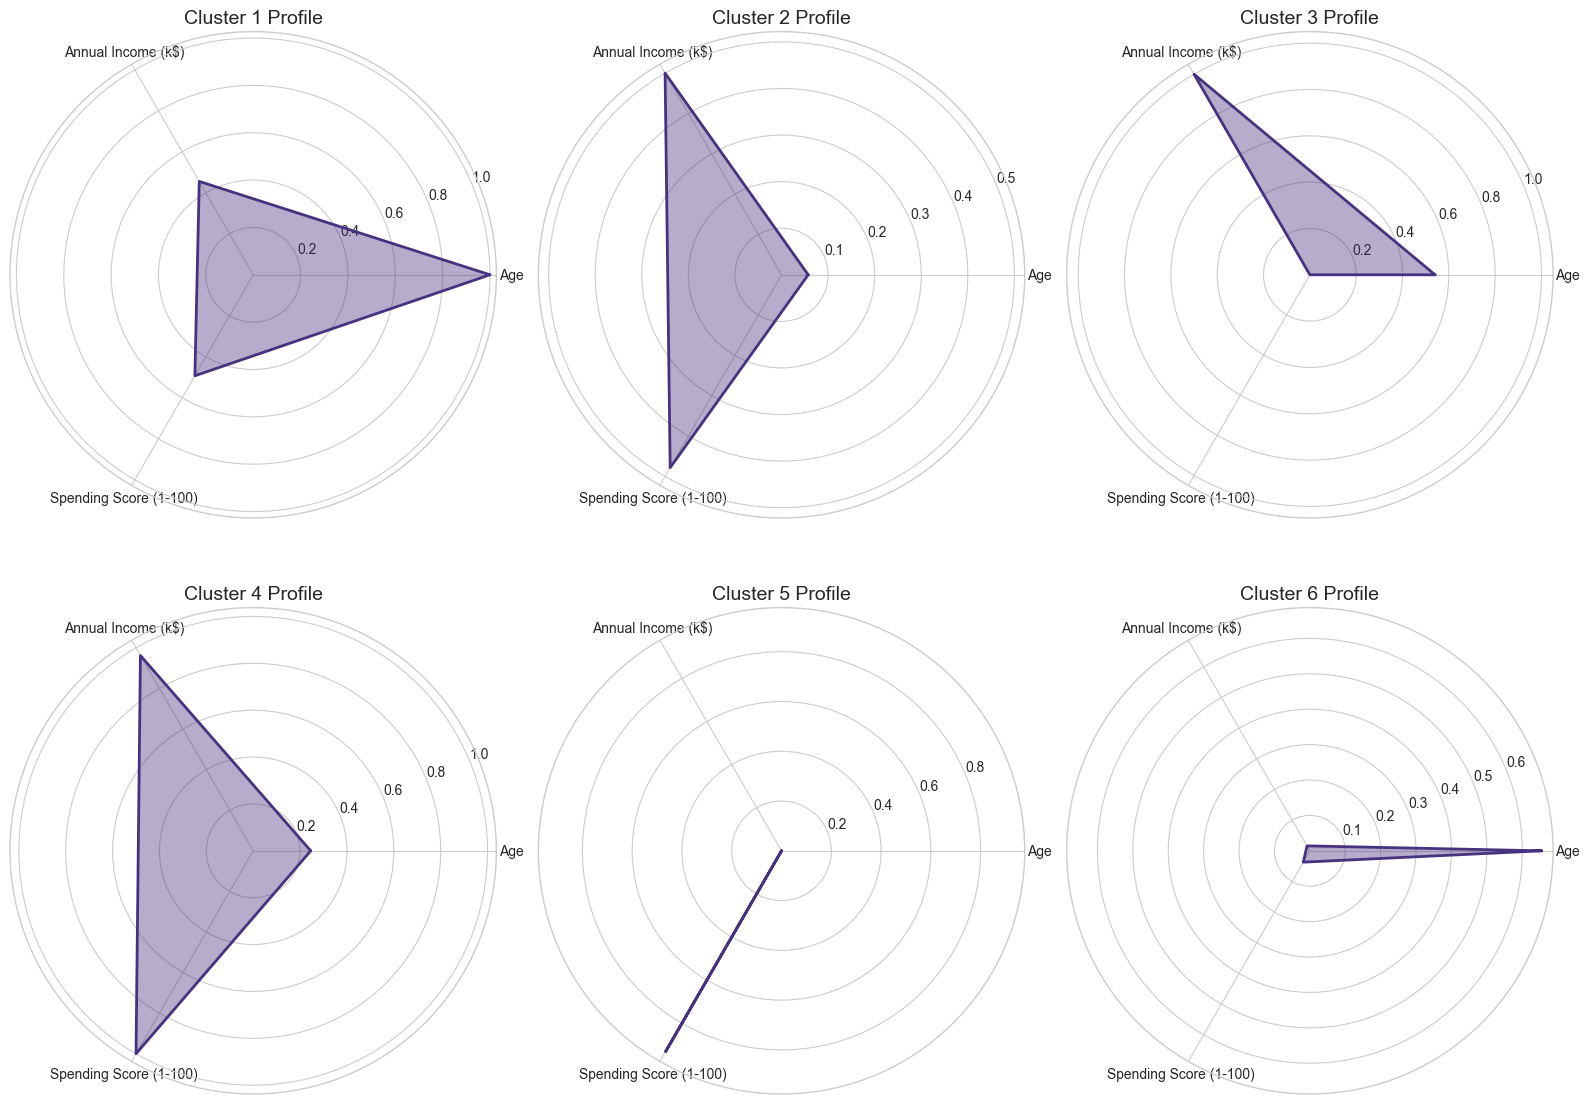

In [23]:
silhouette_analysis(X_3d_scaled, labels_3d, 'Silhouette Analysis for Age-Income-Spending Clusters')
cluster_df_3d = analyze_clusters(df_processed, labels_3d, features_3d)

**Overall Summary of the Five Clusters**

**Interpreting Each Cluster**  
- **Cluster 1**:  
  - **Moderate Income (~\$55k), Moderate Spending (~50), Age ~42**  
  - Fairly balanced group of middle‐aged customers with average income and spending.  
- **Cluster 2**:  
  - **High Income (~\$86k), High Spending (~82), Age ~33**  
  - Younger, well‐paid, and big spenders.  
- **Cluster 3**:  
  - **Low Income (~\$26k), High Spending (~79), Age ~25**  
  - Younger, lower earners, but still spend a lot.  
- **Cluster 4**:  
  - **High Income (~\$88k), Low Spending (~17), Age ~41**  
  - Older or middle‐aged, wealthier, but spend minimally.  
- **Cluster 5**:  
  - **Low Income (~\$26k), Low Spending (~21), Age ~45**  
  - Middle‐aged, lower income, and low spenders.

  __________

### - Map PCA clusters back to original data for analysis

Gender                                 Age                 \
             mean median min max       std       mean median min max   
Cluster                                                                
1        0.823529    1.0   0   1  0.386953  29.911765   31.0  18  40   
2        0.823529    1.0   0   1  0.385013  47.647059   48.0  19  70   
3        0.129630    0.0   0   1  0.339050  49.222222   49.0  20  68   
4        0.180328    0.0   0   1  0.387651  27.295082   28.0  18  40   

                   Annual Income (k$)                             \
               std               mean median min  max        std   
Cluster                                                            
1         6.703087          81.500000   77.5  46  137  22.774587   
2        13.395258          74.627451   73.0  39  137  23.044271   
3        10.555633          46.222222   47.5  16   79  18.963387   
4         5.559809          49.819672   48.0  15   88  22.880493   

        Spending Score (1-100)                            
                          mean median min max        std  
Cluster                                                   
1                    73.882353   75.0  41  97  16.629227  
2                    30.862745   32.0   1  60  18.026669  
3                    34.000000   40.0   3  59  17.882214  
4                    67.508197   73.0  29  99  18.164639

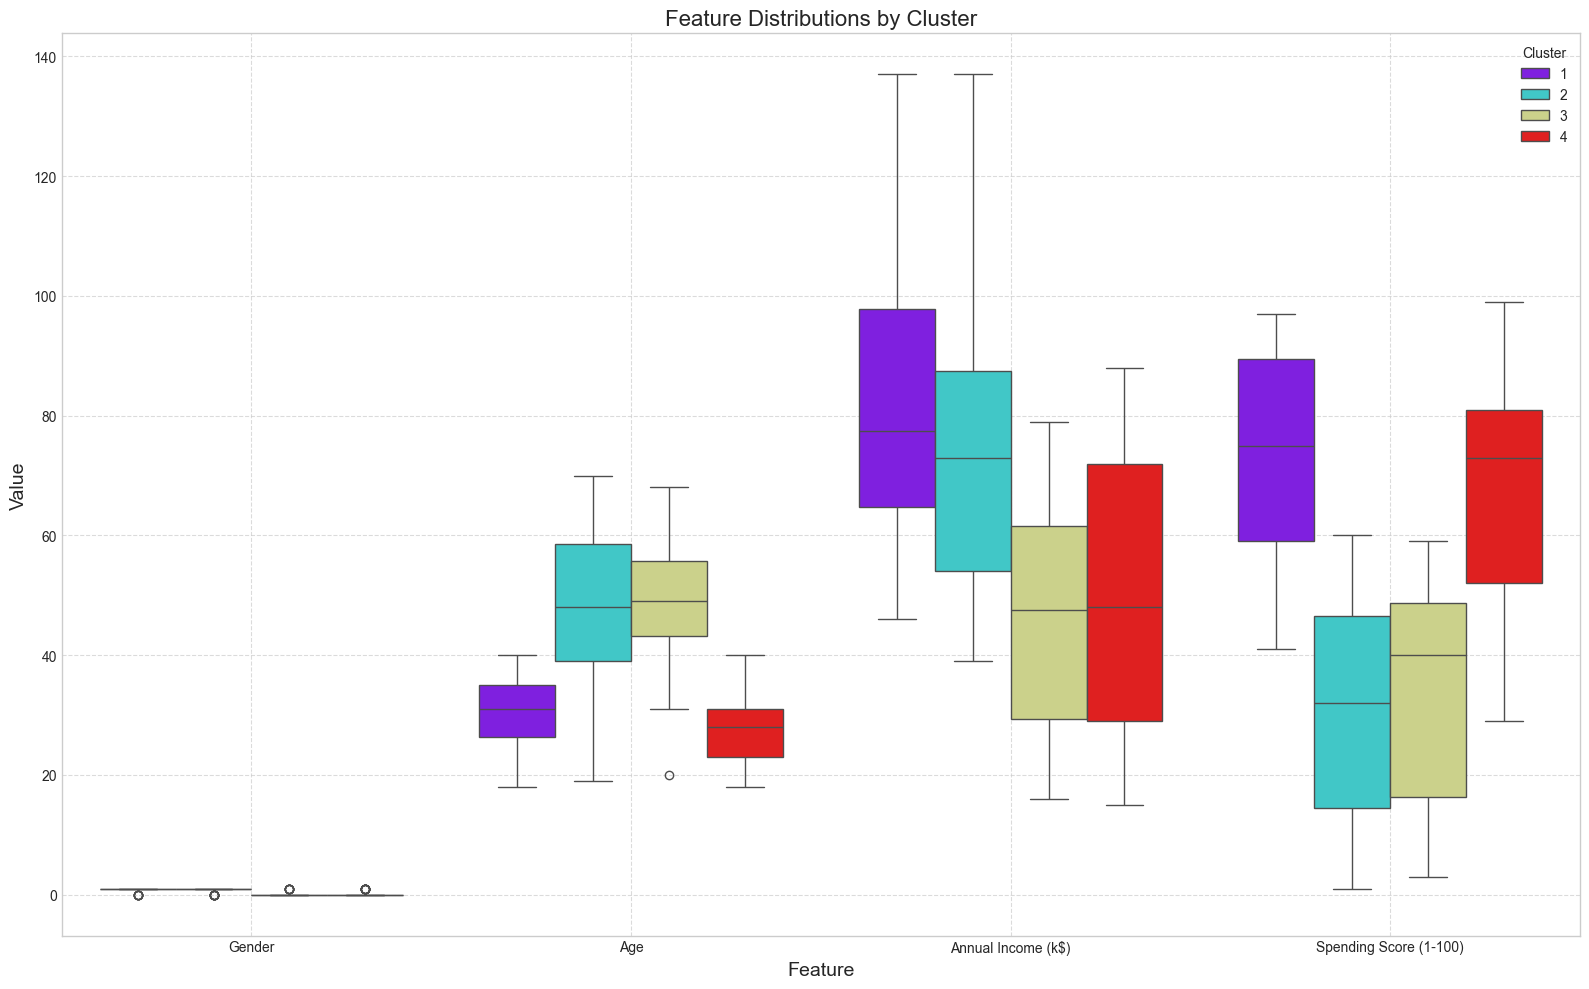

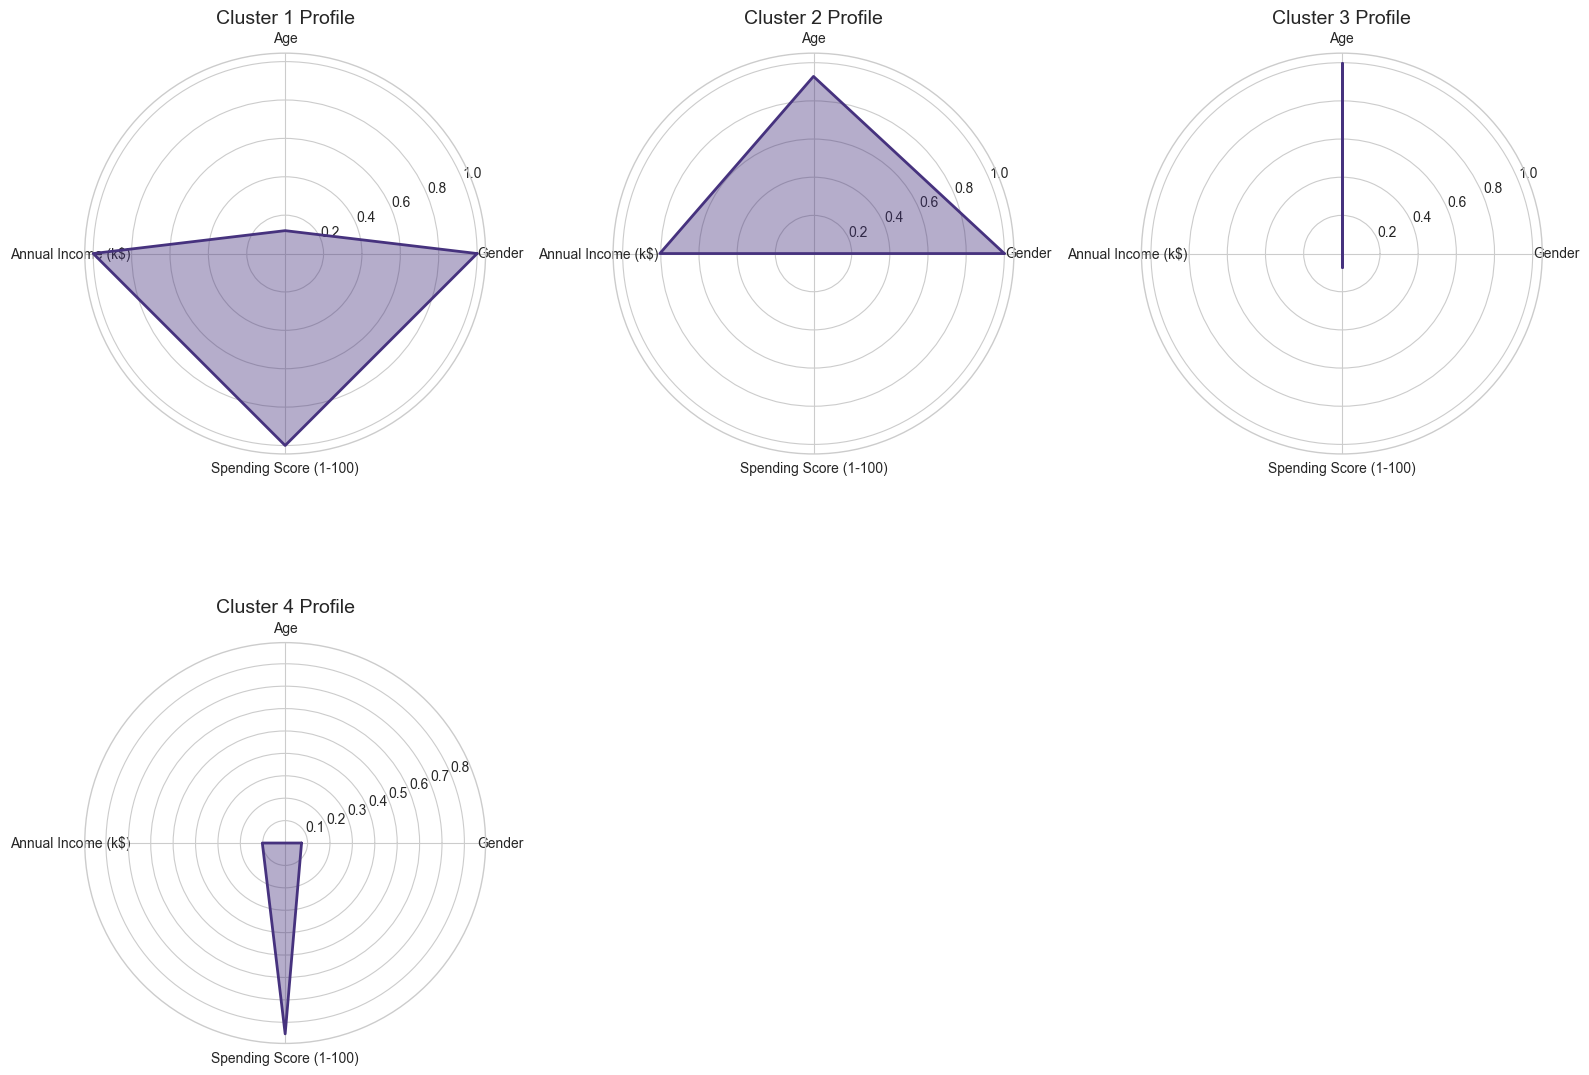

Gender  Age  Annual Income (k$)  Spending Score (1-100)  Cluster
0         1   19                  15                      39        4
1         1   21                  15                      81        4
2         0   20                  16                       6        3
3         0   23                  16                      77        4
4         0   31                  17                      40        3
..      ...  ...                 ...                     ...      ...
195       0   35                 120                      79        1
196       0   45                 126                      28        2
197       1   32                 126                      74        1
198       1   32                 137                      18        2
199       1   30                 137                      83        1

[200 rows x 5 columns]

In [24]:
# Map PCA clusters back to original data for analysis
df_pca_clusters = df_processed.copy()
df_pca_clusters['Cluster'] = labels_pca + 1
analyze_clusters(df_processed, labels_pca, features_all)

#### Conslution and **Short Summary of the Clusters**  

- **Cluster 1:** High income, high spending  
- **Cluster 2:** Older, moderate income, high spending  
- **Cluster 3:** Older, moderate income, moderate spending  
- **Cluster 4:** Younger, lower income, low spending


________

### 7. Business Insights and Recommendations

In [25]:
def interpret_clusters(cluster_df, feature_names):
    """Generate business insights based on cluster characteristics."""
    # Calculate cluster means for all features
    cluster_means = cluster_df.groupby('Cluster')[feature_names].mean().round(2)
    print("Cluster Profiles (Mean Values):")
    display(cluster_means)
    
    # Calculate standard deviation to see intra-cluster variability
    cluster_std = cluster_df.groupby('Cluster')[feature_names].std().round(2)
    print("\nCluster Variability (Standard Deviation):")
    display(cluster_std)
    
    # Calculate percentage of males/females in each cluster
    if 'Gender' in cluster_df.columns:
        gender_distribution = cluster_df.groupby('Cluster')['Gender'].mean().round(2)
        print("\nPercentage of Males in Each Cluster:")
        for cluster, male_pct in gender_distribution.items():
            print(f"Cluster {cluster}: {male_pct*100:.1f}% males, {(1-male_pct)*100:.1f}% females")
    
    # Calculate cluster sizes
    cluster_sizes = cluster_df['Cluster'].value_counts().sort_index()
    total_customers = len(cluster_df)
    
    print("\nCluster Sizes:")
    for cluster, size in cluster_sizes.items():
        print(f"Cluster {cluster}: {size} customers ({size/total_customers*100:.1f}% of total)")

    print("\nDetailed Cluster Insights:")
    for cluster in cluster_means.index:
        print(f"\nCluster {cluster} Analysis:")
        
        # Get values for this cluster
        values = cluster_means.loc[cluster]
        
        # Create insights based on the values
        if 'Annual Income (k$)' in values and 'Spending Score (1-100)' in values:
            income = values['Annual Income (k$)']
            spending = values['Spending Score (1-100)']
            
            # Income assessment
            if income > 80:
                income_level = "very high income"
            elif income > 60:
                income_level = "high income"
            elif income > 40:
                income_level = "moderate income"
            else:
                income_level = "lower income"
                
            # Spending assessment
            if spending > 80:
                spending_level = "very high spending"
            elif spending > 60:
                spending_level = "high spending"
            elif spending > 40:
                spending_level = "moderate spending"
            else:
                spending_level = "conservative spending"
                
            print(f"- {income_level.capitalize()} customers with {spending_level} habits")
            print(f"- Average income: ${income:.0f}k, Average spending score: {spending:.1f}")
        
        # Age assessment if available
        if 'Age' in values:
            age = values['Age']
            if age > 55:
                print(f"- Older demographic (avg. age: {age:.1f})")
            elif age > 35:
                print(f"- Middle-aged demographic (avg. age: {age:.1f})")
            else:
                print(f"- Younger demographic (avg. age: {age:.1f})")
        
        # Gender assessment if available
        if 'Gender' in cluster_df.columns:
            gender_pct = cluster_df[cluster_df['Cluster'] == cluster]['Gender'].mean()
            if gender_pct > 0.7:
                print(f"- Predominantly male ({gender_pct*100:.1f}%)")
            elif gender_pct < 0.3:
                print(f"- Predominantly female ({(1-gender_pct)*100:.1f}%)")
            else:
                print(f"- Mixed gender distribution")
        
        # Size assessment
        size = cluster_sizes.get(cluster, 0)
        size_pct = size / total_customers * 100
        print(f"- Represents {size_pct:.1f}% of customer base ({size} customers)")
    
    print("\nRecommended Marketing Strategies:")
    for cluster in cluster_means.index:
        values = cluster_means.loc[cluster]
        print(f"\nFor Cluster {cluster}:")
        
        # Customized recommendations based on cluster characteristics
        if 'Annual Income (k$)' in values and 'Spending Score (1-100)' in values:
            income = values['Annual Income (k$)']
            spending = values['Spending Score (1-100)']
            
            # High value customers (high income, high spending)
            if income > 60 and spending > 60:
                print("- Premium loyalty programs and VIP experiences")
                print("- Exclusive product launches and premium service offerings")
                print("- Personalized shopping assistance and concierge services")
                print("- Targeted emails featuring luxury products and experiences")
            
            # High income but low spending
            elif income > 60 and spending < 40:
                print("- Targeted promotions to increase engagement and spending")
                print("- Premium product awareness campaigns")
                print("- Incentives to increase shopping frequency")
                print("- Personalized recommendations based on browsing history")
            
            # Low income but high spending
            elif income < 40 and spending > 60:
                print("- Budget-friendly loyalty rewards")
                print("- Special financing options and payment plans")
                print("- Value-oriented promotions that maintain their enthusiasm")
                print("- Early access to sales events and limited offers")
            
            # Low income and low spending
            elif income < 40 and spending < 40:
                print("- Cost-effective mass promotions")
                print("- Heavy discounts and clearance events")
                print("- Basic loyalty programs with immediate rewards")
                print("- Flash sales and limited-time offers")
            
            # Balanced income and spending
            else:
                print("- Balanced approach with mid-tier loyalty programs")
                print("- Promotions on popular items")
                print("- Regular engagement through newsletters and seasonal campaigns")
                print("- Mix of value and quality messaging in communications")
    
    # Highlight key differentiators between clusters
    print("\nKey Cluster Differentiators:")
    for feature in feature_names:
        max_val = cluster_means[feature].max()
        min_val = cluster_means[feature].min()
        if max_val - min_val > 0:  # Only if there's variation
            print(f"\n{feature}:")
            sorted_clusters = cluster_means.sort_values(by=feature, ascending=False)
            for i, (cluster, row) in enumerate(sorted_clusters.iterrows()):
                if i == 0:
                    print(f"- Highest in Cluster {cluster} ({row[feature]:.1f})")
                elif i == len(sorted_clusters) - 1:
                    print(f"- Lowest in Cluster {cluster} ({row[feature]:.1f})")



In [26]:
print("Insights for 2D Clustering (Income vs. Spending):")
# First create the cluster dataframe for 2D analysis
cluster_df_2d = df_processed.copy()
cluster_df_2d['Cluster'] = labels_2d + 1  # Adding 1 to make clusters 1-indexed for readability

# Now generate insights for 2D clustering
print("Insights for 2D Clustering (Income vs. Spending):")
interpret_clusters(cluster_df_2d, features_2d)


Insights for 2D Clustering (Income vs. Spending):
Insights for 2D Clustering (Income vs. Spending):
Cluster Profiles (Mean Values):


Annual Income (k$)  Spending Score (1-100)
Cluster                                            
1                     55.30                   49.52
2                     86.54                   82.13
3                     25.73                   79.36
4                     88.20                   17.11
5                     26.30                   20.91


Cluster Variability (Standard Deviation):


Annual Income (k$)  Spending Score (1-100)
Cluster                                            
1                      8.99                    6.53
2                     16.31                    9.36
3                      7.57                   10.50
4                     16.40                    9.95
5                      7.89                   13.02


Percentage of Males in Each Cluster:
Cluster 1: 41.0% males, 59.0% females
Cluster 2: 46.0% males, 54.0% females
Cluster 3: 41.0% males, 59.0% females
Cluster 4: 54.0% males, 46.0% females
Cluster 5: 39.0% males, 61.0% females

Cluster Sizes:
Cluster 1: 81 customers (40.5% of total)
Cluster 2: 39 customers (19.5% of total)
Cluster 3: 22 customers (11.0% of total)
Cluster 4: 35 customers (17.5% of total)
Cluster 5: 23 customers (11.5% of total)

Detailed Cluster Insights:

Cluster 1 Analysis:
- Moderate income customers with moderate spending habits
- Average income: $55k, Average spending score: 49.5
- Mixed gender distribution
- Represents 40.5% of customer base (81 customers)

Cluster 2 Analysis:
- Very high income customers with very high spending habits
- Average income: $87k, Average spending score: 82.1
- Mixed gender distribution
- Represents 19.5% of customer base (39 customers)

Cluster 3 Analysis:
- Lower income customers with high spending habits
- Average income: $26k, Ave

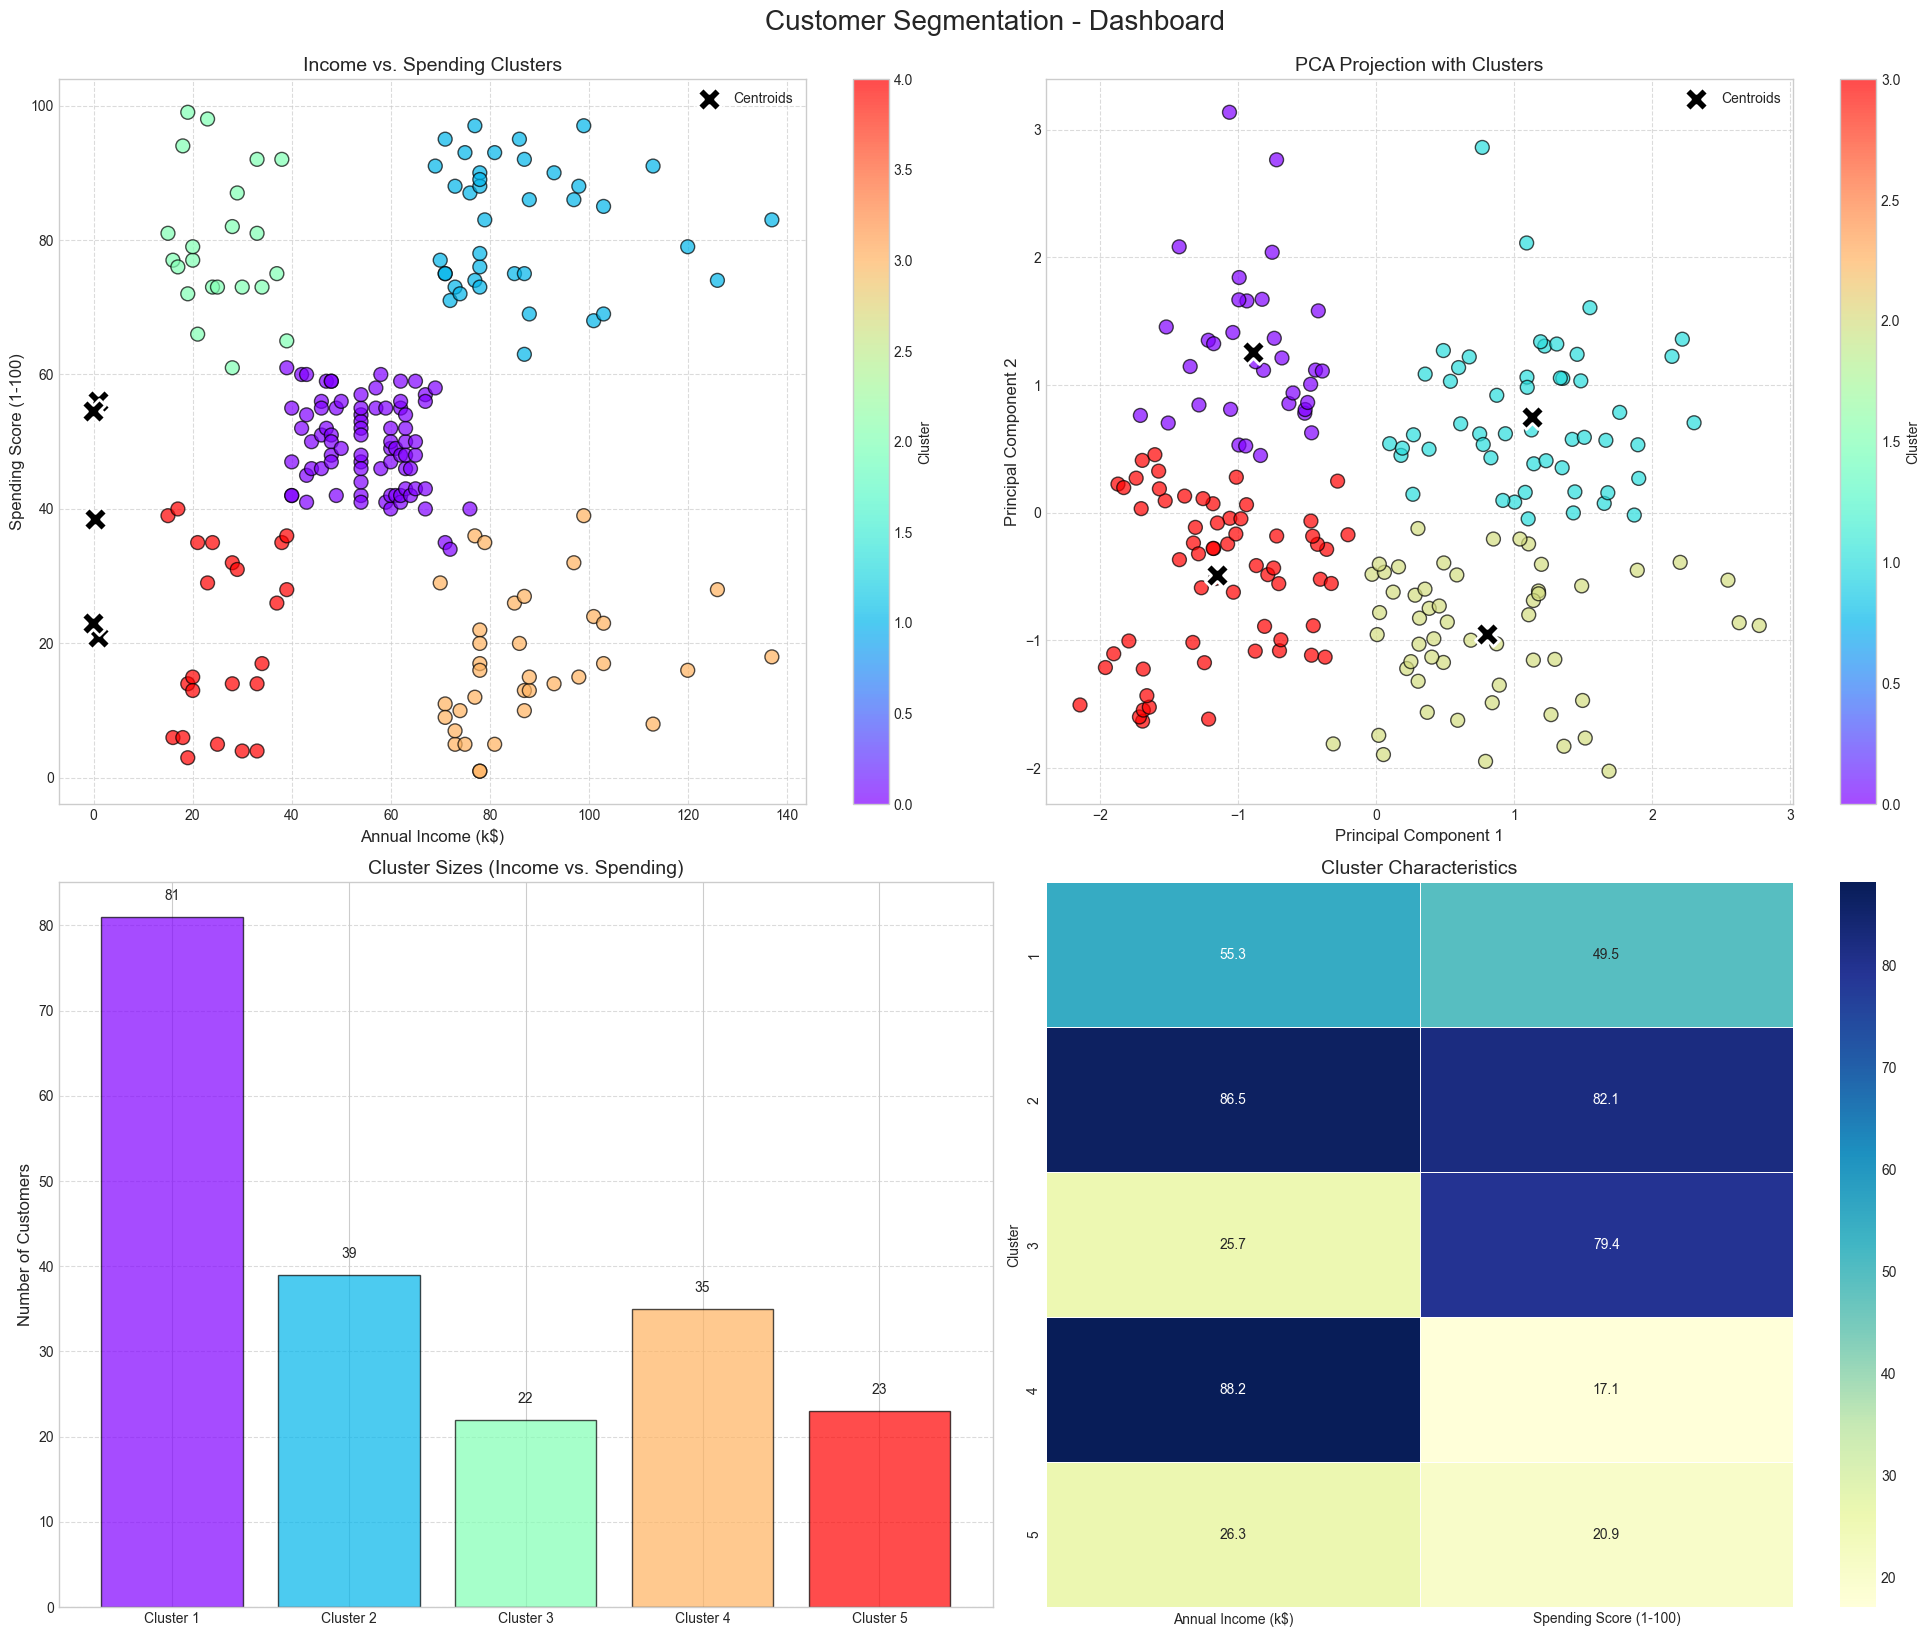

In [27]:
# Create a final dashboard-like visualization to summarize findings
plt.figure(figsize=(20, 16))

# 1. Income vs. Spending with cluster labels
plt.subplot(2, 2, 1)
scatter = plt.scatter(
    df_processed['Annual Income (k$)'], 
    df_processed['Spending Score (1-100)'],
    c=labels_2d, 
    cmap='rainbow',
    s=100, 
    alpha=0.7,
    edgecolor='k'
)
plt.colorbar(scatter, label='Cluster')
plt.scatter(
    kmeans_2d.cluster_centers_[:, 0] * scaler.scale_[0] + scaler.mean_[0], 
    kmeans_2d.cluster_centers_[:, 1] * scaler.scale_[1] + scaler.mean_[1],
    s=300, c='black', marker='X', label='Centroids',
    edgecolor='white', linewidth=2
)
plt.title('Income vs. Spending Clusters', fontsize=14)
plt.xlabel('Annual Income (k$)', fontsize=12)
plt.ylabel('Spending Score (1-100)', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

# 2. PCA projection with cluster labels
plt.subplot(2, 2, 2)
scatter = plt.scatter(
    X_pca[:, 0], X_pca[:, 1],
    c=labels_pca, 
    cmap='rainbow',
    s=100, 
    alpha=0.7,
    edgecolor='k'
)
plt.colorbar(scatter, label='Cluster')
plt.scatter(
    centroids_pca[:, 0], centroids_pca[:, 1],
    s=300, c='black', marker='X', label='Centroids',
    edgecolor='white', linewidth=2
)
plt.title('PCA Projection with Clusters', fontsize=14)
plt.xlabel('Principal Component 1', fontsize=12)
plt.ylabel('Principal Component 2', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

# 3. Cluster sizes and distributions
plt.subplot(2, 2, 3)
cluster_sizes = pd.Series(labels_2d).value_counts().sort_index()
plt.bar(
    [f'Cluster {i+1}' for i in range(len(cluster_sizes))],
    cluster_sizes.values,
    color=plt.cm.rainbow(np.linspace(0, 1, len(cluster_sizes))),
    alpha=0.7, edgecolor='k'
)
plt.title('Cluster Sizes (Income vs. Spending)', fontsize=14)
plt.ylabel('Number of Customers', fontsize=12)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
for i, v in enumerate(cluster_sizes.values):
    plt.text(i, v + 2, str(v), ha='center')

# 4. Feature distributions by cluster
plt.subplot(2, 2, 4)
cluster_means = df_processed.copy()
cluster_means['Cluster'] = labels_2d + 1  # 1-indexed for readability
cluster_means = cluster_means.groupby('Cluster')[features_2d].mean()

# Create a heatmap of cluster means
sns.heatmap(
    cluster_means, 
    annot=True, 
    cmap='YlGnBu',
    linewidths=0.5,
    fmt='.1f'
)
plt.title('Cluster Characteristics', fontsize=14)

plt.tight_layout()
plt.suptitle('Customer Segmentation - Dashboard', fontsize=20, y=1.02)
plt.show()

## Cosine Similarity-Based Recommendation System with LLM Integration

#### - Import necessary libraries for the recommendation system

In [28]:
# Install necessary packages
# !pip install langchain langchain_openai pandas scikit-learn

# Import necessary libraries
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import pandas as pd
import os

# Import LangChain components with version-compatible imports
from langchain_openai import ChatOpenAI
from langchain.prompts import ChatPromptTemplate
# Use the correct import path for StrOutputParser
from langchain_core.output_parsers import StrOutputParser  
from langchain_core.messages import HumanMessage
from dotenv import load_dotenv

load_dotenv()  

# Initialize the Chat model
chat_model = ChatOpenAI(
    model="gpt-4o-mini",  
    temperature=0.7
)

def generate_cluster_recommendations(df, cluster_column='Cluster'):
    """
    Generate recommendations based on cluster characteristics
    """
    # Create a dictionary to store recommendations for each cluster
    cluster_recommendations = {}
    
    # Get unique clusters
    unique_clusters = df[cluster_column].unique()
    
    print(f"Generating recommendations for {len(unique_clusters)} customer segments...")
    
    for cluster_id in unique_clusters:
        # Filter customers in the current cluster
        cluster_customers = df[df[cluster_column] == cluster_id]
        
        # Define cluster characteristics based on means
        cluster_profile = cluster_customers.mean().to_dict()
        
        # Generate recommendations based on cluster characteristics
        if 'Annual Income (k$)' in df.columns and 'Spending Score (1-100)' in df.columns:
            income = cluster_profile['Annual Income (k$)']
            spending = cluster_profile['Spending Score (1-100)']
            
            # Simple recommendation logic based on cluster profile
            if income > 80 and spending > 60:  # High income, high spending
                recommendation = "Premium product recommendations, loyalty programs, exclusive events"
                marketing_budget = "High"
                priority = "Very High"
            elif income > 80 and spending <= 60:  # High income, low spending
                recommendation = "Premium product trials, targeted discounts on luxury items"
                marketing_budget = "Medium-High"
                priority = "High"
            elif income <= 80 and spending > 60:  # Low income, high spending
                recommendation = "Value-based loyalty programs, credit offers, installment options"
                marketing_budget = "Medium"
                priority = "Medium"
            else:  # Low income, low spending
                recommendation = "Special promotions, discount bundles, seasonal sales"
                marketing_budget = "Low"
                priority = "Standard"
        
        # Store recommendations
        cluster_recommendations[cluster_id] = {
            'profile': cluster_profile,
            'recommendation': recommendation,
            'marketing_budget': marketing_budget,
            'priority': priority
        }
    
    return cluster_recommendations

def find_similar_customers(df, customer_id, n=5, features=None):
    """
    Find similar customers using cosine similarity
    
    Parameters:
    -----------
    df : pandas DataFrame
        DataFrame containing customer data
    customer_id : int
        ID of the target customer
    n : int
        Number of similar customers to return
    features : list
        List of features to use for similarity comparison
        
    Returns:
    --------
    list
        List of tuples (customer_id, similarity_score)
    """
    # Select features for similarity calculation
    if features is None:
        features = ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']
    
    # Check if customer_id exists
    if customer_id not in df.index:
        return []
    
    # Extract feature vectors
    X = df[features].values
    
    # Get the target customer vector
    customer_vector = X[df.index == customer_id]
    
    # Calculate cosine similarity
    similarities = cosine_similarity(customer_vector, X)[0]
    
    # Create a list of (index, similarity) tuples, excluding the target customer
    similar_customers = [(idx, similarities[i]) for i, idx in enumerate(df.index) if idx != customer_id]
    
    # Sort by similarity score (highest first)
    similar_customers.sort(key=lambda x: x[1], reverse=True)
    
    # Return top n similar customers
    return similar_customers[:n]

def generate_marketing_message_with_langchain(cluster_id, cluster_info):
    """
    Use LangChain and an LLM to generate personalized marketing messages
    """
    income = cluster_info['profile'].get('Annual Income (k$)', 0)
    spending = cluster_info['profile'].get('Spending Score (1-100)', 0)
    age = cluster_info['profile'].get('Age', 'unknown')
    recommendation = cluster_info['recommendation']
    marketing_budget = cluster_info['marketing_budget']
    priority = cluster_info['priority']
    
    # Create a descriptive summary of the customer segment
    if income > 80 and spending > 60:
        segment_description = "high income, high spending customers who are likely to respond to premium offerings"
    elif income > 80 and spending <= 60:
        segment_description = "high income but conservative spending customers who need incentives to increase spending"
    elif income <= 80 and spending > 60:
        segment_description = "moderate income but high spending customers who are likely loyal but price-conscious"
    else:
        segment_description = "budget-conscious customers who respond best to special offers and promotions"
    
    # Create the message directly without prompts/chains (alternative approach)
    message = chat_model.invoke(
        f"""You are an expert retail marketing specialist crafting personalized email campaigns.
        
        Create a marketing email for Customer Segment {cluster_id} with the following characteristics:
        - Average Age: {age}
        - Average Annual Income: ${income:.1f}k
        - Average Spending Score: {spending:.1f}/100
        - Segment Description: {segment_description}
        - Recommended Strategy: {recommendation}
        - Marketing Budget: {marketing_budget}
        - Customer Priority: {priority}
        
        The email should include:
        1. An attention-grabbing subject line
        2. A personalized greeting
        3. A main offer or promotion appropriate for this segment
        4. A compelling call to action
        5. A professional signature
        
        Keep the tone appropriate for the customer segment and make the message concise but effective."""
    )
    
    return message.content

def recommend_for_customer(customer_id, df, recommendations, chat_model):
    """
    Generate personalized recommendations for a specific customer using LangChain and cosine similarity
    """
    # Get the customer data
    customer = df[df.index == customer_id]
    if customer.empty:
        return "Customer not found"
    
    # Get the customer's cluster
    cluster_id = customer['Cluster'].values[0]
    
    # Get the cluster recommendations
    cluster_recommendation = recommendations.get(cluster_id, None)
    if not cluster_recommendation:
        return "No recommendations available for this customer's segment"
    
    # Find similar customers using cosine similarity
    similar_customers = find_similar_customers(df, customer_id, n=3)
    similar_customer_ids = [cust_id for cust_id, _ in similar_customers]
    
    # Extract customer details
    customer_income = customer['Annual Income (k$)'].values[0]
    customer_spending = customer['Spending Score (1-100)'].values[0]
    customer_age = customer['Age'].values[0] if 'Age' in customer.columns else "unknown"
    customer_gender = customer['Gender'].values[0] if 'Gender' in customer.columns else "unknown"
    
    # Generate recommendation using direct model invocation with similarity data
    response = chat_model.invoke(
        f"""As an AI retail recommendation specialist, create a personalized shopping recommendation for a specific customer.

Customer Details:
- ID: {customer_id}
- Age: {customer_age}
- Gender: {customer_gender}
- Annual Income: ${customer_income}k
- Spending Score: {customer_spending}/100
- Customer Segment: {cluster_id}

Segment Recommendation Strategy: {cluster_recommendation['recommendation']}
Segment Priority Level: {cluster_recommendation['priority']}

Similar Customer IDs: {similar_customer_ids}
(These customers have similar profiles based on cosine similarity analysis)

Based on this information, provide:
1. A personalized greeting addressing their specific situation
2. 3-5 specific product or service recommendations tailored to this customer
3. A personalized shopping tip that would appeal to this customer profile
4. A brief explanation of how these recommendations leverage insights from similar customers

Keep it concise but personal, and focus on providing value based on their profile."""
    )
    
    return response.content

#### - Marketing recommendations message

#### -  Generate and display recommendations for all clusters
    

In [29]:
def display_cluster_recommendations(df, chat_model=None):
    """
    Generate and display recommendations for all clusters
    
    Args:
        df: DataFrame with customer data and cluster assignments
        chat_model: Optional LLM chat model for generating personalized messages
    
    Returns:
        Dictionary of recommendations for each cluster
    """
    try:
        # Generate recommendations for all clusters
        recommendations = generate_cluster_recommendations(df)
        
        # Display recommendations and marketing messages
        print("\n" + "="*80)
        print("CLUSTER RECOMMENDATIONS AND MARKETING STRATEGY")
        print("="*80)
        
        for cluster_id, cluster_info in recommendations.items():
            print(f"\nCLUSTER {cluster_id}:")
            print(f"Average Income: ${cluster_info['profile']['Annual Income (k$)']:.2f}k")
            print(f"Average Spending Score: {cluster_info['profile']['Spending Score (1-100)']:.2f}/100")
            print(f"Recommended Strategy: {cluster_info['recommendation']}")
            print(f"Marketing Budget Allocation: {cluster_info['marketing_budget']}")
            print(f"Customer Priority: {cluster_info['priority']}")
            
            if chat_model:
                print("\nSample Personalized Marketing Message (Generated by LLM):")
                print("-"*60)
                try:
                    marketing_message = generate_marketing_message_with_langchain(cluster_id, cluster_info)
                    print(marketing_message)
                except Exception as e:
                    print(f"Unable to generate LLM message: {e}")
                    print("Please ensure you've set up your API key correctly.")
                print("-"*60)
        
        return recommendations
        
    except Exception as e:
        print(f"An error occurred: {e}")
        print("This code requires the clustering to be performed first.")
        return None


def test_customer_recommendation(customer_id, df, recommendations=None, chat_model=None):
    """
    Generate and display a personalized recommendation for a specific customer
    
    Args:
        customer_id: ID of the customer to generate recommendation for
        df: DataFrame with customer data and cluster assignments
        recommendations: Optional pre-generated recommendations dictionary
        chat_model: Optional LLM chat model for generating personalized messages
    
    Returns:
        The customer recommendation message
    """
    try:
        # Generate recommendations if not provided
        if recommendations is None:
            recommendations = generate_cluster_recommendations(df)
        
        # Check if customer exists
        if customer_id >= len(df):
            print(f"\nCustomer #{customer_id} does not exist in dataset.")
            return None
        
        print(f"\n{'='*30} CUSTOMER #{customer_id} RECOMMENDATION {'='*30}")
        
        # Get customer details for display
        customer = df.iloc[customer_id]
        cluster_id = customer['Cluster']
        income = customer['Annual Income (k$)'] if 'Annual Income (k$)' in df.columns else 'N/A'
        spending = customer['Spending Score (1-100)'] if 'Spending Score (1-100)' in df.columns else 'N/A'
        age = customer['Age'] if 'Age' in df.columns else 'N/A'
        gender = customer['Gender'] if 'Gender' in df.columns else 'N/A'
        
        # Display customer information
        print(f"Customer ID: {customer_id}")
        print(f"Cluster: {cluster_id}")
        print(f"Gender: {gender}")
        print(f"Age: {age}")
        print(f"Annual Income: ${income}k")
        print(f"Spending Score: {spending}/100")
        print("\nPERSONALIZED RECOMMENDATION:")
        print("-"*60)
        
        if chat_model:
            try:
                recommendation = recommend_for_customer(customer_id, df, recommendations, chat_model)
                print(recommendation)
                return recommendation
            except Exception as e:
                print(f"Unable to generate customer recommendation: {e}")
                return None
        else:
            print("Chat model not provided. Please provide a chat model for personalized recommendations.")
            return None
            
    except Exception as e:
        print(f"An error occurred: {e}")
        return None


def batch_customer_recommendations(customer_ids, df, recommendations=None, chat_model=None):
    """
    Generate recommendations for a batch of customers
    
    Args:
        customer_ids: List of customer IDs to generate recommendations for
        df: DataFrame with customer data and cluster assignments
        recommendations: Optional pre-generated recommendations dictionary
        chat_model: Optional LLM chat model for generating personalized messages
    """
    # Generate recommendations if not provided
    if recommendations is None:
        recommendations = generate_cluster_recommendations(df)
    
    print("\nEXAMPLE INDIVIDUAL CUSTOMER RECOMMENDATIONS")
    print("="*80)
    
    # Process each customer
    results = {}
    for customer_id in customer_ids:
        recommendation = test_customer_recommendation(customer_id, df, recommendations, chat_model)
        results[customer_id] = recommendation
    
    return results



#### Generate and display all cluster recommendations

In [30]:
# Generate and display all cluster recommendations
recommendations = display_cluster_recommendations(cluster_df_2d, chat_model)

# Test a specific customer
test_customer_recommendation(10, cluster_df_2d, recommendations, chat_model)

# Test multiple customers at once
#batch_customer_recommendations([10, 50, 100, 150], cluster_df_2d, recommendations, chat_model)


Generating recommendations for 5 customer segments...

CLUSTER RECOMMENDATIONS AND MARKETING STRATEGY

CLUSTER 5:
Average Income: $26.30k
Average Spending Score: 20.91/100
Recommended Strategy: Special promotions, discount bundles, seasonal sales
Marketing Budget Allocation: Low
Customer Priority: Standard

Sample Personalized Marketing Message (Generated by LLM):
------------------------------------------------------------
**Subject Line:** Unlock Exclusive Savings Just for You!

---

**Dear Valued Customer,**

We understand that every dollar counts, and that’s why we’re excited to bring you some fantastic deals that fit your budget! 

**🌟 Special Offer: Enjoy 20% Off Your Next Purchase! 🌟**  
As a thank you for being a part of our community, we’re offering you an exclusive 20% discount on your next order. This is the perfect opportunity to stock up on your essentials or treat yourself to something special without breaking the bank!

**🛒 Plus, check out our Discount Bundles!**  
Get e

"### Personalized Greeting\nHello! We hope you're having a wonderful day. We understand that as a valued customer with a keen eye for savings, you might be looking for some great deals that suit your lifestyle and budget. We're here to help you find the best options tailored just for you!\n\n### Product Recommendations\n1. **Comfortable Walking Shoes** - A pair of lightweight, supportive walking shoes can enhance your daily activities. Look for brands like New Balance or Skechers, which often have seasonal discounts.\n  \n2. **Gardening Tools Set** - If you enjoy gardening, a basic set of ergonomic gardening tools can make your hobby more enjoyable. Check out local gardening stores for bundle deals.\n\n3. **Memory Foam Pillow** - A quality memory foam pillow can improve your sleep quality. Look for promotions at stores like Target or Walmart, where they frequently offer discounts on home goods.\n\n4. **Grocery Store Gift Cards** - Consider purchasing gift cards for local grocery stores

### Find a customer with specific criteria

In [31]:
def find_customers_with_criteria(cluster_df_2d, recommendations, chat_model):
    # Example: Customer with highest spending score
    high_spender_id = cluster_df_2d['Spending Score (1-100)'].idxmax()
    print(f"Customer with highest spending score has ID: {high_spender_id}")
    test_customer_recommendation(high_spender_id, cluster_df_2d, recommendations, chat_model)

    # Example: Random customer from a specific cluster (e.g., cluster 3)
    if 3 in cluster_df_2d['Cluster'].unique():
        cluster_3_customers = cluster_df_2d[cluster_df_2d['Cluster'] == 3]
        customer_id_3 = cluster_3_customers.index[np.random.randint(0, len(cluster_3_customers))]
        print(f"Randomly selected customer from Cluster 3 has ID: {customer_id_3}")
        test_customer_recommendation(customer_id_3, cluster_df_2d, recommendations, chat_model)

# Call the function
find_customers_with_criteria(cluster_df_2d, recommendations, chat_model)

Customer with highest spending score has ID: 11

============================== CUSTOMER #11 RECOMMENDATION ==============================
Customer ID: 11
Cluster: 3
Gender: 0
Age: 35
Annual Income: $19k
Spending Score: 99/100

PERSONALIZED RECOMMENDATION:
------------------------------------------------------------
### Personalized Greeting

Hello! We're thrilled to see you back at our store. With your impressive spending score and dedication to finding value, we’ve curated some fantastic recommendations just for you!

### Product and Service Recommendations

1. **Budget-Friendly Tech Gadgets**: Consider the latest budget smartphones or tablets. Brands like Xiaomi and Motorola offer excellent performance without breaking the bank, making them perfect for your tech needs.

2. **Affordable Apparel Subscription**: Check out a clothing subscription service that offers stylish outfits at an affordable price. This way, you can refresh your wardrobe without overspending.

3. **Grocery Delive